# Automate the detection of brain tumors. 

This is a research project about how to automate the detection of brain tumors. With this research i want to reduce the misdiagnoses of tumor. 
In this research, you will find a classification part and a segmentation part. 
The classification part contains different models. Like an own classification CNN and different transfer learning models.
In the segmentation part, you will find an Unet and a deeplabv3plus. 
I resized my images to 128x128px, because my GPU can't handle it. 
You will also find a small application that makes a predicting on a list of images and if the image contains a tumor it will be forwarded to the segmentation part. 

### Example of the application

<img src="./diagram/brain.png">
<img src="./diagram/TumorDetected.png">


In [2]:

%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.utils import shuffle

import cv2


import matplotlib.image as mpimg
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from scipy import ndimage

from sklearn.preprocessing import StandardScaler
import seaborn as sns




import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization,concatenate
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras import backend as K
from tensorflow.python.keras.layers.core import Dropout, Lambda
from tensorflow.python.keras.layers.core import * 
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.text import Tokenizer

import glob


from tensorflow.keras.callbacks import *
# Voor GPU support
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

pd.set_option('display.max_rows',10000)
pd.set_option('display.max_columns',10000)

## Data

In [2]:
path = "./dataset/kaggle_3m/"


In [3]:
#toon dataset csv
#show dataset csv
data = pd.read_csv('./dataset/kaggle_3m/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [4]:
#toon 10 rows
#show 10 rows
data.head(10)

Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0  TCGA_CS_4941            2.0                 4.0             2        2.0   
1  TCGA_CS_4942            1.0                 5.0             2        1.0   
2  TCGA_CS_4943            1.0                 5.0             2        1.0   
3  TCGA_CS_4944            NaN                 5.0             2        1.0   
4  TCGA_CS_5393            4.0                 5.0             2        1.0   
5  TCGA_CS_5395            2.0                 4.0             2        2.0   
6  TCGA_CS_5396            3.0                 3.0             2        3.0   
7  TCGA_CS_5397            NaN                 4.0             1        2.0   
8  TCGA_CS_6186            2.0                 4.0             1        2.0   
9  TCGA_CS_6188            2.0                 4.0             3        2.0   

   RPPACluster  OncosignCluster  COCCluster  histological_type  \
0          NaN              3.0           2                1.0   
1          1.0              2.0           1                1.0   
2          2.0              2.0           1                1.0   
3          2.0              1.0           1                1.0   
4          2.0              3.0           1                1.0   
5          NaN              3.0           2                3.0   
6          2.0              2.0           3                3.0   
7          3.0              3.0           2                1.0   
8          1.0              3.0           2                2.0   
9          3.0              3.0           2                1.0   

   neoplasm_histologic_grade  tumor_tissue_site  laterality  tumor_location  \
0                        2.0                1.0         3.0             2.0   
1                        2.0                1.0         3.0             2.0   
2                        2.0                1.0         1.0             2.0   
3                        1.0                1.0         3.0             6.0   
4                        2.0                1.0         1.0             6.0   
5                        1.0                1.0         3.0             5.0   
6                        2.0                1.0         3.0             2.0   
7                        2.0                1.0         1.0             6.0   
8                        2.0                1.0         3.0             2.0   
9                        2.0                1.0         3.0             6.0   

   gender  age_at_initial_pathologic  race  ethnicity  death01  
0     2.0                       67.0   3.0        2.0      1.0  
1     1.0                       44.0   2.0        NaN      1.0  
2     2.0                       37.0   3.0        NaN      0.0  
3     2.0                       50.0   3.0        NaN      0.0  
4     2.0                       39.0   3.0        NaN      0.0  
5     2.0                       43.0   2.0        NaN      1.0  
6     1.0                       53.0   3.0        2.0      0.0  
7     1.0                       54.0   3.0        2.0      1.0  
8     2.0                       58.0   3.0        2.0      1.0  
9     2.0                       48.0   3.0        2.0      0.0

### Load images and masks


In [5]:
# Separate images and masks in the directory
masks_dir = glob.glob(path + "*/*_mask*")

images_dir = []
for img in masks_dir:
    images_dir.append(img.replace("_mask", ""))

In [6]:
# Create a new datafarme for brain images and masks
data_brain = pd.DataFrame(data={
                                "file_images":images_dir, 
                                "file_masks":masks_dir
                                })
data_brain.head()# Create a new datafarme for brain images and masks
data_brain = pd.DataFrame(data={
                                "file_images":images_dir, 
                                "file_masks":masks_dir
                                })
data_brain.head()

file_images  \
0  ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
1  ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
2  ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
3  ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
4  ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   

                                          file_masks  
0  ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...  
1  ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...  
2  ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...  
3  ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...  
4  ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...

In [7]:
mask = cv2.imread(data_brain["file_masks"][1200])
np.max(mask) # -> er is een mask 

255

In [8]:
mask = cv2.imread(data_brain["file_masks"][12])
np.max(mask) # -> er is geen mask 

0

In [9]:
#wel of geen tumor
# tumor or non
def positive_negative_diagnosis(file_masks):
    mask = cv2.imread(file_masks)
    value = np.max(mask)
    if value > 0:
        #als max gevonden value groter is dan null -> er is een mask aanwezig
        # if max founded value in mask -> it means it has a tumor
        return 1
    else:
        return 0

In [10]:
data_brain["mask"] = data_brain["file_masks"].apply(lambda x: positive_negative_diagnosis(x))

In [11]:
# 0 -> geen tumor , 1 -> wel tumor
data_brain


file_images  \
0     ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
1     ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
2     ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
3     ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
4     ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
5     ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
6     ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
7     ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
8     ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
9     ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
10    ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
11    ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
12    ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
13    ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
14    ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
15    ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
16    ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
17    ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
18    ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
19    ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
20    ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
21    ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
22    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
23    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
24    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
25    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
26    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
27    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
28    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
29    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
30    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
31    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
32    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
33    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
34    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
35    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
36    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
37    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
38    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
39    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
40    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
41    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
42    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
43    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
44    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
45    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
46    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
47    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
48    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
49    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
50    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
51    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
52    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
53    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
54    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
55    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
56    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
57    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
58    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
59    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
60    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
61    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
62    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
63    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
64    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
65    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
66    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
67    ./dataset/kaggle_3m\TCGA_C

In [12]:
data_brain["mask"].value_counts()

0    2560
1    1376
Name: mask, dtype: int64

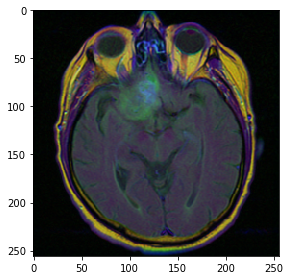

In [13]:
#print one image
image = io.imread(data_brain.file_images[1])
imshow(image)
plt.show()

In [14]:
def show_image(df):
    fig, ax = plt.subplots(nrows=10, ncols=3, figsize=(20, 40))
    count = 0
    i = 0
    for mask in df["mask"]:
        if mask == 1:
            # Show images
            image = io.imread(df.file_images[i])
            ax[count][0].title.set_text("Brain MRI")
            ax[count][0].imshow(image)

            # Show masks
            mask = io.imread(df.file_masks[i])
            ax[count][1].title.set_text("Mask Brain MRI")
            ax[count][1].imshow(mask, cmap="gray")

            # Show MRI Brain with mask
            image[mask == 255] = (0, 255, 0)    # Here, we want to modify the color of pixel at the position of mask
            ax[count][2].title.set_text("MRI Brain with mask")
            ax[count][2].imshow(image)
            count += 1
            i += 1
        if count == 10:
            break
    fig.tight_layout()
    plt.show()

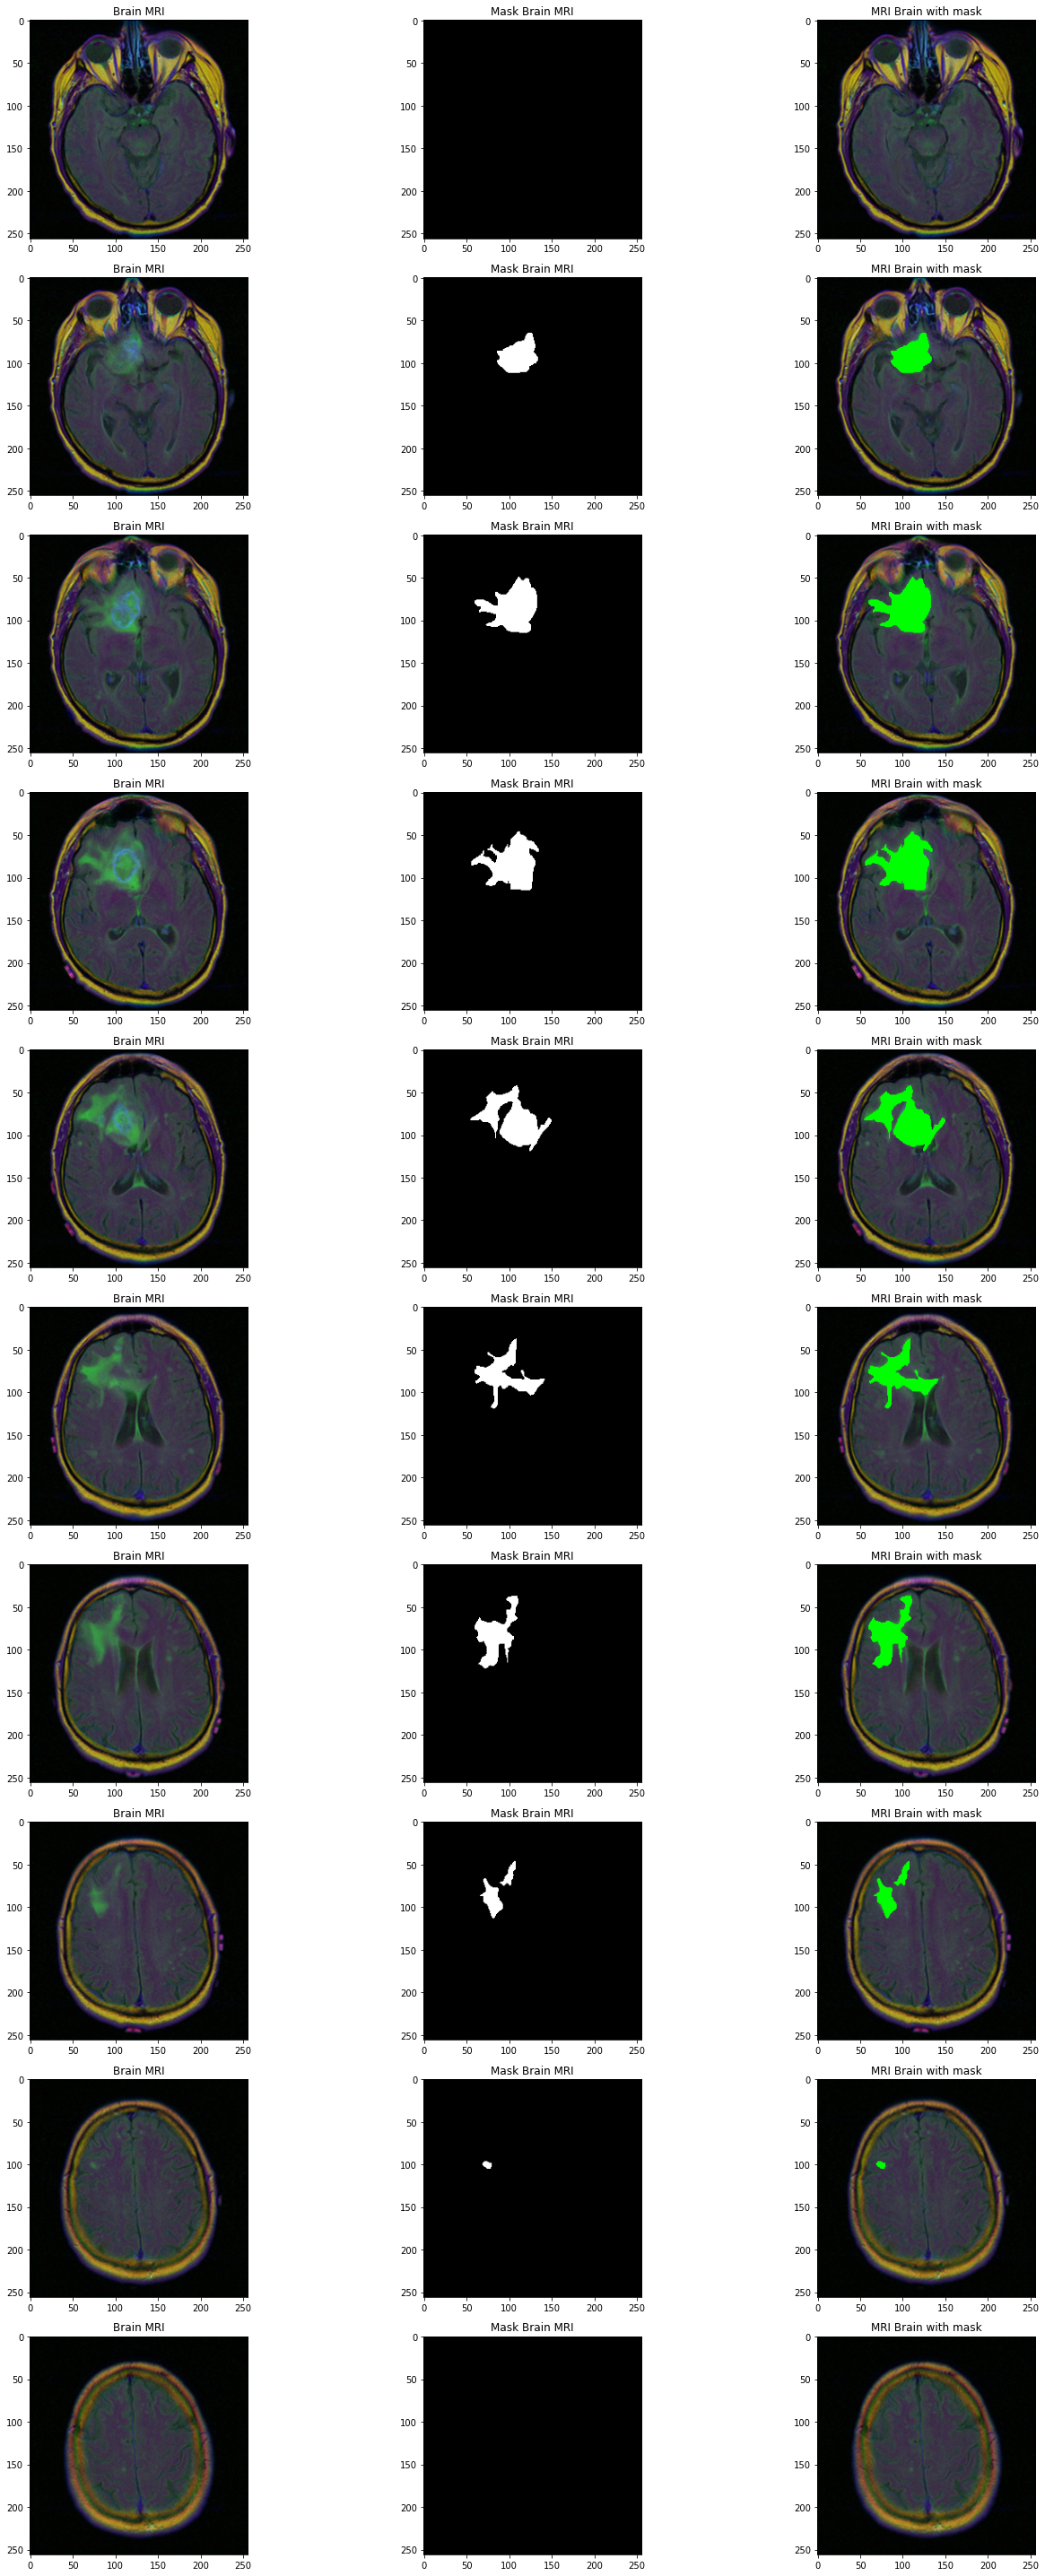

In [15]:
show_image(data_brain)

In [16]:
#split dataset in tumor and without
data_brain_with = data_brain[data_brain['mask'] == 1].values
data_brain_without = data_brain[data_brain['mask'] == 0].values


In [17]:
# Create the pandas DataFrame
data_brain_with = pd.DataFrame(data_brain_with, columns = ['file_images','file_masks','mask'])
data_brain_with




file_images  \
0     ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
1     ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
2     ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
3     ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
4     ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
5     ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
6     ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
7     ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
8     ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
9     ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
10    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
11    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
12    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
13    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
14    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
15    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
16    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
17    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
18    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
19    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
20    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
21    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
22    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
23    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
24    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
25    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
26    ./dataset/kaggle_3m\TCGA_CS_4944_20010208\TCGA...   
27    ./dataset/kaggle_3m\TCGA_CS_4944_20010208\TCGA...   
28    ./dataset/kaggle_3m\TCGA_CS_4944_20010208\TCGA...   
29    ./dataset/kaggle_3m\TCGA_CS_4944_20010208\TCGA...   
30    ./dataset/kaggle_3m\TCGA_CS_4944_20010208\TCGA...   
31    ./dataset/kaggle_3m\TCGA_CS_4944_20010208\TCGA...   
32    ./dataset/kaggle_3m\TCGA_CS_4944_20010208\TCGA...   
33    ./dataset/kaggle_3m\TCGA_CS_4944_20010208\TCGA...   
34    ./dataset/kaggle_3m\TCGA_CS_4944_20010208\TCGA...   
35    ./dataset/kaggle_3m\TCGA_CS_5393_19990606\TCGA...   
36    ./dataset/kaggle_3m\TCGA_CS_5393_19990606\TCGA...   
37    ./dataset/kaggle_3m\TCGA_CS_5393_19990606\TCGA...   
38    ./dataset/kaggle_3m\TCGA_CS_5393_19990606\TCGA...   
39    ./dataset/kaggle_3m\TCGA_CS_5393_19990606\TCGA...   
40    ./dataset/kaggle_3m\TCGA_CS_5393_19990606\TCGA...   
41    ./dataset/kaggle_3m\TCGA_CS_5393_19990606\TCGA...   
42    ./dataset/kaggle_3m\TCGA_CS_5393_19990606\TCGA...   
43    ./dataset/kaggle_3m\TCGA_CS_5395_19981004\TCGA...   
44    ./dataset/kaggle_3m\TCGA_CS_5395_19981004\TCGA...   
45    ./dataset/kaggle_3m\TCGA_CS_5396_20010302\TCGA...   
46    ./dataset/kaggle_3m\TCGA_CS_5396_20010302\TCGA...   
47    ./dataset/kaggle_3m\TCGA_CS_5396_20010302\TCGA...   
48    ./dataset/kaggle_3m\TCGA_CS_5396_20010302\TCGA...   
49    ./dataset/kaggle_3m\TCGA_CS_5396_20010302\TCGA...   
50    ./dataset/kaggle_3m\TCGA_CS_5396_20010302\TCGA...   
51    ./dataset/kaggle_3m\TCGA_CS_5396_20010302\TCGA...   
52    ./dataset/kaggle_3m\TCGA_CS_5396_20010302\TCGA...   
53    ./dataset/kaggle_3m\TCGA_CS_5396_20010302\TCGA...   
54    ./dataset/kaggle_3m\TCGA_CS_5396_20010302\TCGA...   
55    ./dataset/kaggle_3m\TCGA_CS_5397_20010315\TCGA...   
56    ./dataset/kaggle_3m\TCGA_CS_5397_20010315\TCGA...   
57    ./dataset/kaggle_3m\TCGA_CS_5397_20010315\TCGA...   
58    ./dataset/kaggle_3m\TCGA_CS_5397_20010315\TCGA...   
59    ./dataset/kaggle_3m\TCGA_CS_5397_20010315\TCGA...   
60    ./dataset/kaggle_3m\TCGA_CS_5397_20010315\TCGA...   
61    ./dataset/kaggle_3m\TCGA_CS_6186_20000601\TCGA...   
62    ./dataset/kaggle_3m\TCGA_CS_6186_20000601\TCGA...   
63    ./dataset/kaggle_3m\TCGA_CS_6186_20000601\TCGA...   
64    ./dataset/kaggle_3m\TCGA_CS_6186_20000601\TCGA...   
65    ./dataset/kaggle_3m\TCGA_CS_6186_20000601\TCGA...   
66    ./dataset/kaggle_3m\TCGA_CS_6186_20000601\TCGA...   
67    ./dataset/kaggle_3m\TCGA_C

In [18]:
data_brain_without = pd.DataFrame(data_brain_without, columns = ['file_images','file_masks','mask'])


In [19]:
data_brain_with.file_images[0]

'./dataset/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11.tif'

In [20]:
data_brain_without.head()

file_images  \
0  ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
1  ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
2  ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
3  ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
4  ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   

                                          file_masks mask  
0  ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...    0  
1  ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...    0  
2  ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...    0  
3  ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...    0  
4  ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...    0

### Separate X, y


In [21]:
#elke row omzetten naar een array (brain_image_with)
# change every row to array (brain_image_with)

brain_image_with = []
y_brain_with = []
image_size = 128

def to_array_with(df):
    count = 0
    i = 0
    for mask in df["mask"]:
        # Show images
       
        image = imread(df.file_images[i])
    
        image = transform.resize(image,(image_size,image_size),mode='constant',anti_aliasing=True)
        brain_image_with.append(image)

        # Show images     
        y_brain_with.append(1)
        
        count += 1
        i += 1
        if count == 1373:
            break

            
to_array_with(data_brain_with)


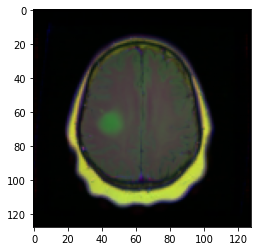

In [22]:
plt.imshow(brain_image_with[12]) 

In [23]:
print(y_brain_with)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [24]:
#elke row omzetten naar een array (brain_image_without)
# change every row to array(brain_image_without)
brain_image_without = []
y_brain_without = []
image_size = 128

def to_array_without(df):
    count = 0
    i = 0
    for mask in df["mask"]:
        # Show images
        image = io.imread(df.file_images[i])
        
        image = transform.resize(image,(image_size,image_size),mode='constant',anti_aliasing=True)
        brain_image_without.append(image)

        # Show images
        #image = io.imread(df.file_masks[i])
        #y_brain_image_without.append(image)
        y_brain_without.append(0)

        
        count += 1
        i += 1
            
        if count == 1373:
            break
to_array_without(data_brain_without)

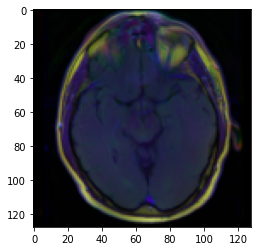

In [25]:
plt.imshow(brain_image_without[132])

In [26]:
print(y_brain_without)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [27]:
# class balance 

print("without tumor:",len(brain_image_without))
print("with tumor:", len(brain_image_with))

without tumor: 1373
with tumor: 1373


In [28]:
# Create a training set and test set. Make sure the datasets are randomized.

X = np.vstack((np.asarray(brain_image_without),np.asarray(brain_image_with)))
y = np.hstack((np.asarray(y_brain_without),np.asarray(y_brain_with)))

In [29]:
print(X.shape)

(2746, 128, 128, 3)


In [30]:
print(y.shape)

(2746,)


In [31]:
# balancedness of the dataset
label_count = np.bincount(y)

print('count klasse 0: ',label_count[0])
print('count klasse 1: ',label_count[1])

print('ratio: ',label_count[0]/label_count[1])


count klasse 0:  1373
count klasse 1:  1373
ratio:  1.0


### Training split


In [32]:

#opsplitsen in train en test (20 samples in testset)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state =0)




#validation split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15, random_state =0)




In [33]:
# balancedness of the dataset
label_count = np.bincount(y_train)

print('count klasse 0: ',label_count[0])
print('count klasse 1: ',label_count[1])

print('ratio: ',label_count[0]/label_count[1])

count klasse 0:  1053
count klasse 1:  1047
ratio:  1.005730659025788


In [34]:
y_train

array([0, 0, 0, ..., 1, 1, 0])

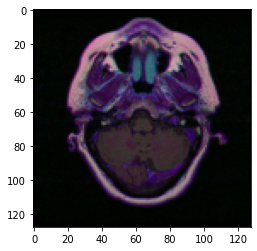

In [35]:
img = X_train[6]
plt.imshow(img)

In [36]:
print(X_val)

[[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.00196078 0.        ]
   ...
   [0.         0.00882353 0.        ]
   [0.         0.00294118 0.        ]
   [0.         0.         0.        ]]

  ...

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.00490196 0.        ]
   ...
   [0.         0.00980392 0.        ]
   [0.         0.00490196 0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0. 

In [37]:
# Image normalization when necessary

# Normalisatie
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')
#X_train /= 255 -> moet niet uitgevoerd worden, want de input is al tussen 0 -> 1  
#X_test /= 255

#original test labels -> voor predictie
y_test_original = y_test
y_train_original = y_train
y_val_original = y_val

# one-hot encoding van de target labels
y_train = to_categorical(y_train) # only on training labels
y_test = to_categorical(y_test) 
y_val = to_categorical(y_val)



### read datafile -> X_train, X_test,.....

In [38]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

print(X_val.shape)
print(y_val.shape)

(2100, 128, 128, 3)
(2100, 2)
(275, 128, 128, 3)
(275, 2)
(371, 128, 128, 3)
(371, 2)


In [39]:
# balancedness of the dataset
label_count = np.bincount(y_train_original)

print('count klasse 0: ',label_count[0])
print('count klasse 1: ',label_count[1])

print('ratio: ',label_count[0]/label_count[1])


count klasse 0:  1053
count klasse 1:  1047
ratio:  1.005730659025788


## Classification - Convolutional neural network

<img src="./Diagram/1_vkQ0hXDaQv57sALXAJquxA.jpeg"/>

"https://www.google.com/url?sa=i&url=https%3A%2F%2Ftowardsdatascience.com%2Fa-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53&psig=AOvVaw2qJdx83wwYo1QTg73U_m-C&ust=1642065574431000&source=images&cd=vfe&ved=0CAgQjRxqFwoTCLCk_5Dxq_UCFQAAAAAdAAAAABAD"


### Own model

In [94]:
%%time
# Neural network

# Model checkpoint
checkpoint_filepath = './Classification_brain_best.h5'

# Early stopping
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,save_weights_only=True, monitor='val_loss',mode='auto',save_best_only=True)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 50)

adam = tf.keras.optimizers.Adam(learning_rate=0.001)

# Neural network parameters
#-------------------------
num_classes = 2
img_rows, img_cols = image_size, image_size
input_shape = (img_rows, img_cols,3) # 1 -> grijs waarden, 3 -> kleur
epochs = 500
batch_size = 32

#------------ layers ----------

OwnClassificationNN=Sequential()

OwnClassificationNN.add(Conv2D(256,(3,3),input_shape=input_shape))
OwnClassificationNN.add(Activation('relu'))
OwnClassificationNN.add(BatchNormalization())
OwnClassificationNN.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers


OwnClassificationNN.add(Dropout(0.1))


OwnClassificationNN.add(Conv2D(128,(3,3)))
OwnClassificationNN.add(Activation('relu'))
OwnClassificationNN.add(MaxPooling2D(pool_size=(2,2)))

OwnClassificationNN.add(Conv2D(64,(3,3)))
OwnClassificationNN.add(Activation('relu'))
OwnClassificationNN.add(BatchNormalization())
OwnClassificationNN.add(MaxPooling2D(pool_size=(2,2)))


OwnClassificationNN.add(Dropout(0.3))

OwnClassificationNN.add(Conv2D(16,(3,3)))
OwnClassificationNN.add(Activation('relu'))
OwnClassificationNN.add(MaxPooling2D(pool_size=(2,2)))

OwnClassificationNN.add(Conv2D(8,(3,3)))
OwnClassificationNN.add(Activation('relu'))
OwnClassificationNN.add(MaxPooling2D(pool_size=(2,2)))


#---------- Classification part ------------------------------
OwnClassificationNN.add(Flatten())
OwnClassificationNN.add(Dropout(0.1)) # ---->> to avoid overfitting 
#Flatten layer to stack the output convolutions from second convolution layer
OwnClassificationNN.add(Dense(4,activation='relu'))
#Dense layer of 64 neurons

OwnClassificationNN.add(Dense(num_classes,activation='softmax'))
#The Final layer with two outputs for two categories

OwnClassificationNN.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])




# Trainen van het CNN
history = OwnClassificationNN.fit(X_train, y_train,batch_size=batch_size, epochs=epochs, validation_data=(X_val,y_val) ,verbose=1,callbacks=[es,mc])


Epoch 1/500
66/66 [==============================] - 4s 63ms/step - loss: 0.6138 - accuracy: 0.6771 - val_loss: 0.6991 - val_accuracy: 0.4555
Epoch 2/500
66/66 [==============================] - 4s 61ms/step - loss: 0.4653 - accuracy: 0.7795 - val_loss: 0.6767 - val_accuracy: 0.6550
Epoch 3/500
66/66 [==============================] - 4s 57ms/step - loss: 0.4067 - accuracy: 0.8176 - val_loss: 0.6725 - val_accuracy: 0.6280
Epoch 4/500
66/66 [==============================] - 4s 57ms/step - loss: 0.3613 - accuracy: 0.8167 - val_loss: 0.6254 - val_accuracy: 0.7385
Epoch 5/500
66/66 [==============================] - 4s 56ms/step - loss: 0.3295 - accuracy: 0.8467 - val_loss: 0.5710 - val_accuracy: 0.7736
Epoch 6/500
66/66 [==============================] - 4s 56ms/step - loss: 0.3308 - accuracy: 0.8448 - val_loss: 0.5592 - val_accuracy: 0.7790
Epoch 7/500
66/66 [==============================] - 4s 58ms/step - loss: 0.3045 - accuracy: 0.8567 - val_loss: 0.4644 - val_accuracy: 0.8383
Epoch 

In [95]:
OwnClassificationNN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 126, 126, 256)     7168      
_________________________________________________________________
activation_10 (Activation)   (None, 126, 126, 256)     0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 126, 126, 256)     1024      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 63, 63, 256)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 63, 63, 256)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 61, 61, 128)       295040    
_________________________________________________________________
activation_11 (Activation)   (None, 61, 61, 128)      

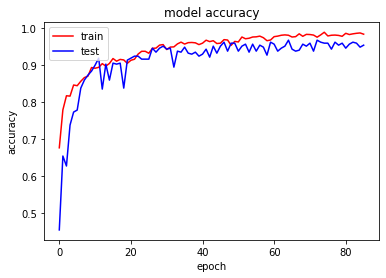

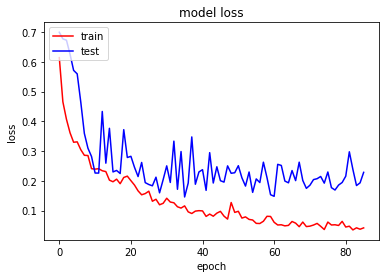

In [96]:
# Plot history
# Check for underfitting / overfitting based on the model loss history
# Determine the optimal number of training epochs. Use early stopping with model checkpoint saving. rezftre

# Accuray 
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [168]:
# Test the neural network on the test set. Use the following metrics: accuracy, recall, 
# precision, f1-score and the ROC/auRoc.

# Loading the the best performing model
OwnClassificationNN.load_weights(checkpoint_filepath)


# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
OwnClassificationNN.save("./Model/OwnClassificationNN.h5")


y_pred = np.argmax(OwnClassificationNN.predict(X_test), axis=-1)


print('\n')
print(classification_report(y_test_original, y_pred))

cf = confusion_matrix(y_test_original, y_pred)
acc_ownModel = accuracy_score(y_test_original, y_pred) * 100

print(cf)
print(acc_ownModel) 




              precision    recall  f1-score   support

           0       0.94      0.97      0.96       144
           1       0.97      0.93      0.95       131

    accuracy                           0.95       275
   macro avg       0.95      0.95      0.95       275
weighted avg       0.95      0.95      0.95       275

[[140   4]
 [  9 122]]
95.27272727272728


In [98]:
print(OwnClassificationNN.evaluate(X_test,y_test))

9/9 [==============================] - 0s 14ms/step - loss: 0.1350 - accuracy: 0.9527
[0.13503168523311615, 0.9527272582054138]


### Augmentation with own  classification model 

In [99]:
# Neural network

# Model checkpoint
checkpoint_filepath_Class_aug = './Classification_brain_best_augmen.h5'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath_Class_aug,save_weights_only=True, monitor='val_loss',mode='auto',save_best_only=True)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 50)



# Neural network parameters
#-------------------------
num_classes = 2
img_rows, img_cols = image_size, image_size
input_shape = (img_rows, img_cols,3) # 1 -> grijs waarden, 3 -> kleur
epochs = 500
batch_size = 64


#------------ layers ----------

OwnClassificationNN_aug=Sequential()


OwnClassificationNN_aug.add(Conv2D(256,(3,3),input_shape=input_shape))
OwnClassificationNN_aug.add(Activation('relu'))
OwnClassificationNN_aug.add(BatchNormalization())
OwnClassificationNN_aug.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers


OwnClassificationNN_aug.add(Dropout(0.1))


OwnClassificationNN_aug.add(Conv2D(128,(3,3)))
OwnClassificationNN_aug.add(Activation('relu'))
OwnClassificationNN_aug.add(MaxPooling2D(pool_size=(2,2)))

OwnClassificationNN_aug.add(Conv2D(64,(3,3)))
OwnClassificationNN_aug.add(Activation('relu'))
OwnClassificationNN_aug.add(BatchNormalization())
OwnClassificationNN_aug.add(MaxPooling2D(pool_size=(2,2)))


OwnClassificationNN_aug.add(Dropout(0.3))

OwnClassificationNN_aug.add(Conv2D(16,(3,3)))
OwnClassificationNN_aug.add(Activation('relu'))
OwnClassificationNN_aug.add(MaxPooling2D(pool_size=(2,2)))

OwnClassificationNN_aug.add(Conv2D(8,(3,3)))
OwnClassificationNN_aug.add(Activation('relu'))
OwnClassificationNN_aug.add(MaxPooling2D(pool_size=(2,2)))


#---------- Classification part ------------------------------
OwnClassificationNN_aug.add(Flatten())
OwnClassificationNN_aug.add(Dropout(0.2)) # ---->> to avoid overfitting 
#Flatten layer to stack the output convolutions from second convolution layer
OwnClassificationNN_aug.add(Dense(4,activation='relu'))
#Dense layer of 64 neurons

OwnClassificationNN_aug.add(Dense(num_classes,activation='softmax'))
#The Final layer with two outputs for two categories

OwnClassificationNN_aug.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])


#### Image augmentation ####

 
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
horizontal_flip=True, fill_mode="nearest")
 
# train the network
history_aug = OwnClassificationNN_aug.fit_generator(aug.flow(X_train, y_train, batch_size=batch_size),callbacks=[es,mc],verbose=1,
steps_per_epoch=len(X_train) // batch_size, epochs=epochs,validation_data = (X_val,y_val))



c:\users\ouassim boutalliss\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/500
32/32 [==============================] - 4s 125ms/step - loss: 0.8041 - accuracy: 0.5059 - val_loss: 0.6930 - val_accuracy: 0.5418
Epoch 2/500
32/32 [==============================] - 4s 122ms/step - loss: 0.6861 - accuracy: 0.5398 - val_loss: 0.6914 - val_accuracy: 0.5256
Epoch 3/500
32/32 [==============================] - 4s 123ms/step - loss: 0.6766 - accuracy: 0.5359 - val_loss: 0.7080 - val_accuracy: 0.5256
Epoch 4/500
32/32 [==============================] - 4s 122ms/step - loss: 0.6702 - accuracy: 0.5874 - val_loss: 0.6953 - val_accuracy: 0.5256
Epoch 5/500
32/32 [==============================] - 4s 124ms/step - loss: 0.6380 - accuracy: 0.6238 - val_loss: 0.6949 - val_accuracy: 0.5256
Epoch 6/500
32/32 [==============================] - 4s 125ms/step - loss: 0.6134 - accuracy: 0.6557 - val_loss: 0.8158 - val_accuracy: 0.5256
Epoch 7/500
32/32 [==============================] - 4s 127ms/step - loss: 0.5682 - accuracy: 0.6970 - val_loss: 1.0407 - val_accuracy: 0.5256

Epoch 58/500
32/32 [==============================] - 4s 122ms/step - loss: 0.2143 - accuracy: 0.9185 - val_loss: 0.2189 - val_accuracy: 0.9003
Epoch 59/500
32/32 [==============================] - 4s 123ms/step - loss: 0.1960 - accuracy: 0.9224 - val_loss: 0.1775 - val_accuracy: 0.9299
Epoch 60/500
32/32 [==============================] - 4s 122ms/step - loss: 0.1725 - accuracy: 0.9322 - val_loss: 0.1639 - val_accuracy: 0.9488
Epoch 61/500
32/32 [==============================] - 4s 123ms/step - loss: 0.1884 - accuracy: 0.9268 - val_loss: 0.1834 - val_accuracy: 0.9380
Epoch 62/500
32/32 [==============================] - 4s 123ms/step - loss: 0.1832 - accuracy: 0.9239 - val_loss: 0.1627 - val_accuracy: 0.9380
Epoch 63/500
32/32 [==============================] - 4s 122ms/step - loss: 0.1795 - accuracy: 0.9293 - val_loss: 0.1684 - val_accuracy: 0.9272
Epoch 64/500
32/32 [==============================] - 4s 123ms/step - loss: 0.1927 - accuracy: 0.9303 - val_loss: 0.1931 - val_accuracy:

Epoch 115/500
32/32 [==============================] - 4s 123ms/step - loss: 0.1375 - accuracy: 0.9474 - val_loss: 0.1129 - val_accuracy: 0.9623
Epoch 116/500
32/32 [==============================] - 4s 123ms/step - loss: 0.1347 - accuracy: 0.9519 - val_loss: 0.1281 - val_accuracy: 0.9596
Epoch 117/500
32/32 [==============================] - 4s 123ms/step - loss: 0.1146 - accuracy: 0.9592 - val_loss: 0.1366 - val_accuracy: 0.9569
Epoch 118/500
32/32 [==============================] - 4s 124ms/step - loss: 0.1067 - accuracy: 0.9587 - val_loss: 0.1330 - val_accuracy: 0.9596
Epoch 119/500
32/32 [==============================] - 4s 122ms/step - loss: 0.1250 - accuracy: 0.9533 - val_loss: 0.1934 - val_accuracy: 0.9488
Epoch 120/500
32/32 [==============================] - 4s 121ms/step - loss: 0.1255 - accuracy: 0.9578 - val_loss: 0.1313 - val_accuracy: 0.9569
Epoch 121/500
32/32 [==============================] - 4s 122ms/step - loss: 0.1161 - accuracy: 0.9561 - val_loss: 0.2847 - val_ac

32/32 [==============================] - 4s 123ms/step - loss: 0.0731 - accuracy: 0.9730 - val_loss: 0.1632 - val_accuracy: 0.9488
Epoch 228/500
32/32 [==============================] - 4s 123ms/step - loss: 0.0679 - accuracy: 0.9754 - val_loss: 0.1167 - val_accuracy: 0.9677
Epoch 229/500
32/32 [==============================] - 4s 127ms/step - loss: 0.0713 - accuracy: 0.9740 - val_loss: 0.1295 - val_accuracy: 0.9542
Epoch 230/500
32/32 [==============================] - 4s 124ms/step - loss: 0.0685 - accuracy: 0.9759 - val_loss: 0.1512 - val_accuracy: 0.9623
Epoch 231/500
32/32 [==============================] - 4s 126ms/step - loss: 0.0841 - accuracy: 0.9700 - val_loss: 0.1462 - val_accuracy: 0.9596
Epoch 232/500
32/32 [==============================] - 4s 125ms/step - loss: 0.0886 - accuracy: 0.9656 - val_loss: 0.1207 - val_accuracy: 0.9677
Epoch 233/500
32/32 [==============================] - 4s 133ms/step - loss: 0.0830 - accuracy: 0.9700 - val_loss: 0.1187 - val_accuracy: 0.9596

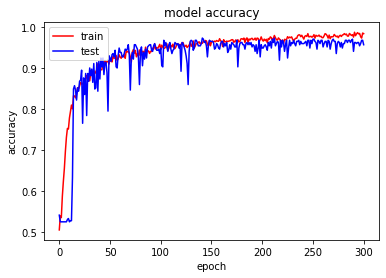

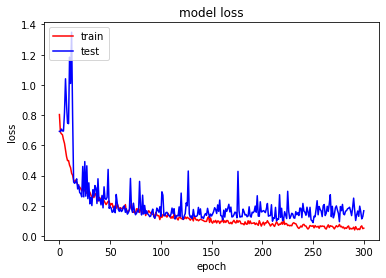

In [100]:
# Plot history
# Check for underfitting / overfitting based on the model loss history
# Determine the optimal number of training epochs. Use early stopping with model checkpoint saving.

# Accuray 
plt.plot(history_aug.history['accuracy'],'r')
plt.plot(history_aug.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history_aug.history['loss'],'r')
plt.plot(history_aug.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [167]:
# Test the neural network on the test set. Use the following metrics: accuracy, recall, 
# precision, f1-score and the ROC/auRoc.

# Loading the the best performing model
OwnClassificationNN_aug.load_weights(checkpoint_filepath_Class_aug)


# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
OwnClassificationNN_aug.save("./Model/OwnClassificationNN_aug.h5")


y_pred = np.argmax(OwnClassificationNN_aug.predict(X_test), axis=-1)


print('\n')
print(classification_report(y_test_original, y_pred))

cf = confusion_matrix(y_test_original, y_pred)
acc_aug = accuracy_score(y_test_original, y_pred) * 100


print(cf)
print(acc_aug) 




              precision    recall  f1-score   support

           0       0.97      0.94      0.96       144
           1       0.94      0.97      0.95       131

    accuracy                           0.96       275
   macro avg       0.96      0.96      0.96       275
weighted avg       0.96      0.96      0.96       275

[[136   8]
 [  4 127]]
95.63636363636364


## Transfer learning classification

### EfficientNetB0

In [344]:
num_classes = 2
adam = tf.keras.optimizers.Adam(lr=0.001)

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False,input_shape=(image_size,image_size,3))



# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(64, activation='relu')(x)
#X = Dropout(0.2) # ---->> to avoid overfitting 
#x = Dense(8, activation='relu')(x)


# and a logistic layer -- let's say we have 200 classes
predictions = Dense(2, activation='softmax')(x)  
# this is the model we will train
EfficientNetB0 = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
EfficientNetB0.compile(optimizer="adam", loss='categorical_crossentropy',metrics=['accuracy'])


checkpoint_filepath_transfer_EfficientNetB0 = './bestmodel_brain_transfer_EfficientNetB0.h5'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath_transfer_EfficientNetB0,save_weights_only=True, monitor='val_loss',mode='auto',save_best_only=True)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)



batch_size =64
epochs = 50
history = EfficientNetB0.fit(X_train, y_train, batch_size=batch_size,validation_data=(X_val,y_val), epochs=epochs, verbose=1,callbacks=[es,mc])




c:\users\ouassim boutalliss\appdata\local\programs\python\python38\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/50
33/33 [==============================] - 6s 83ms/step - loss: 0.7063 - accuracy: 0.4966 - val_loss: 0.6946 - val_accuracy: 0.4891
Epoch 2/50
33/33 [==============================] - 1s 41ms/step - loss: 0.6975 - accuracy: 0.4870 - val_loss: 0.6940 - val_accuracy: 0.5109
Epoch 3/50
33/33 [==============================] - 1s 40ms/step - loss: 0.6988 - accuracy: 0.5067 - val_loss: 0.6945 - val_accuracy: 0.5109
Epoch 4/50
33/33 [==============================] - 1s 41ms/step - loss: 0.7005 - accuracy: 0.4817 - val_loss: 0.6974 - val_accuracy: 0.5109
Epoch 5/50
33/33 [==============================] - 1s 40ms/step - loss: 0.7100 - accuracy: 0.4832 - val_loss: 0.6945 - val_accuracy: 0.5109
Epoch 6/50
33/33 [==============================] - 1s 40ms/step - loss: 0.6979 - accuracy: 0.4880 - val_loss: 0.6929 - val_accuracy: 0.5109
Epoch 7/50
33/33 [==============================] - 1s 40ms/step - loss: 0.6958 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.4891
Epoch 8/50
33

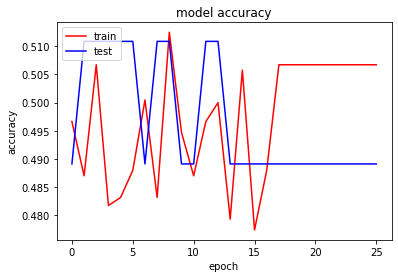

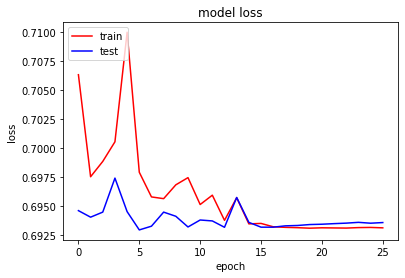

In [345]:
# Plot history
# Check for underfitting / overfitting based on the model loss history
# Determine the optimal number of training epochs. Use early stopping with model checkpoint saving.




# Accuray 
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [346]:
# Test the neural network on the test set. Use the following metrics: accuracy, recall, 
# precision, f1-score and the ROC/auRoc.

# Loading the the best performing model
EfficientNetB0.load_weights(checkpoint_filepath_transfer_EfficientNetB0)

# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
EfficientNetB0.save("./Model/EfficientNetB0.h5")


y_pred = np.argmax(EfficientNetB0.predict(X_test), axis=-1)

print('\n')
print(classification_report(y_test_original, y_pred))

cf = confusion_matrix(y_test_original, y_pred)

print(cf) 
print(accuracy_score(y_test_original, y_pred) * 100) 

c:\users\ouassim boutalliss\appdata\local\programs\python\python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '




              precision    recall  f1-score   support

           0       0.49      1.00      0.66       135
           1       0.00      0.00      0.00       138

    accuracy                           0.49       273
   macro avg       0.25      0.50      0.33       273
weighted avg       0.24      0.49      0.33       273

[[135   0]
 [138   0]]
49.45054945054945


c:\users\ouassim boutalliss\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### InceptionV3

In [347]:
num_classes = 2
adam = tf.keras.optimizers.Adam(lr=0.001)

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False,input_shape=(image_size,image_size,3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(32, activation='relu')(x)
X = Dropout(0.3) # ---->> to avoid overfitting 
x = Dense(16, activation='relu')(x)
X = Dropout(0.1) # ---->> to avoid overfitting 
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
InceptionV3 = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
InceptionV3.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])


checkpoint_filepath_transfer_InceptionV3 = './bestmodel_brain_transfer_InceptionV3'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath_transfer_InceptionV3,save_weights_only=True, monitor='val_loss',mode='auto',save_best_only=True)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)



batch_size =64
epochs = 50
history = InceptionV3.fit(X_train, y_train, batch_size=batch_size,validation_data=(X_val,y_val), epochs=epochs, verbose=1,callbacks=[es,mc])




Epoch 1/50
33/33 [==============================] - 6s 95ms/step - loss: 0.5240 - accuracy: 0.7450 - val_loss: 0.4462 - val_accuracy: 0.7609
Epoch 2/50
33/33 [==============================] - 1s 36ms/step - loss: 0.3965 - accuracy: 0.7963 - val_loss: 0.3974 - val_accuracy: 0.7935
Epoch 3/50
33/33 [==============================] - 1s 36ms/step - loss: 0.3348 - accuracy: 0.8237 - val_loss: 0.3743 - val_accuracy: 0.8016
Epoch 4/50
33/33 [==============================] - 1s 37ms/step - loss: 0.2925 - accuracy: 0.8511 - val_loss: 0.3578 - val_accuracy: 0.8234
Epoch 5/50
33/33 [==============================] - 1s 37ms/step - loss: 0.2792 - accuracy: 0.8761 - val_loss: 0.3332 - val_accuracy: 0.8342
Epoch 6/50
33/33 [==============================] - 1s 37ms/step - loss: 0.2389 - accuracy: 0.8991 - val_loss: 0.3110 - val_accuracy: 0.8750
Epoch 7/50
33/33 [==============================] - 1s 36ms/step - loss: 0.1979 - accuracy: 0.9169 - val_loss: 0.2869 - val_accuracy: 0.8750
Epoch 8/50
33

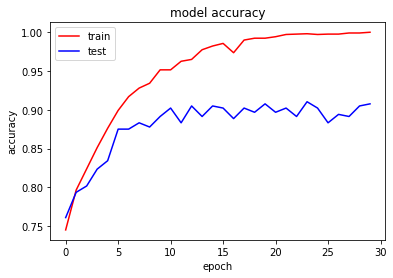

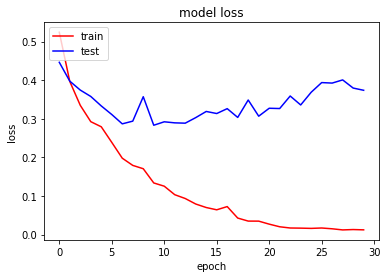

In [348]:
# Plot history
# Check for underfitting / overfitting based on the model loss history
# Determine the optimal number of training epochs. Use early stopping with model checkpoint saving.




# Accuray 
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [349]:
# Test the neural network on the test set. Use the following metrics: accuracy, recall, 
# precision, f1-score and the ROC/auRoc.

# Loading the the best performing model
InceptionV3.load_weights(checkpoint_filepath_transfer_InceptionV3)

# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
InceptionV3.save("./Model/InceptionV3.h5")



y_pred = np.argmax(InceptionV3.predict(X_test), axis=-1)

print('\n')
print(classification_report(y_test_original, y_pred))

cf = confusion_matrix(y_test_original, y_pred)

print(cf)
print(accuracy_score(y_test_original, y_pred) * 100) 




              precision    recall  f1-score   support

           0       0.91      0.86      0.88       135
           1       0.87      0.91      0.89       138

    accuracy                           0.89       273
   macro avg       0.89      0.89      0.89       273
weighted avg       0.89      0.89      0.89       273

[[116  19]
 [ 12 126]]
88.64468864468864


### ResNet50

In [64]:
num_classes = 2
adam = tf.keras.optimizers.Adam(lr=0.001)

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False,input_shape=(image_size,image_size,3))



# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#x = Dense(128, activation='relu')(x)
#X = Dropout(0.2) # ---->> to avoid overfitting 
#x = Dense(4, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
ResNet50 = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
ResNet50.compile(optimizer="Adam", loss='categorical_crossentropy',metrics=['accuracy'])


checkpoint_filepath_transfer_ResNet50 = './bestmodel_brain_transfer_resnet50'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath_transfer_ResNet50,save_weights_only=True, monitor='val_loss',mode='auto',save_best_only=True)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)


batch_size =32
epochs = 200
history = ResNet50.fit(X_train, y_train, batch_size=batch_size,validation_data=(X_val,y_val), epochs=epochs, verbose=1,callbacks=[es,mc])



Epoch 1/200
66/66 [==============================] - 4s 35ms/step - loss: 0.6866 - accuracy: 0.5533 - val_loss: 0.6824 - val_accuracy: 0.5175
Epoch 2/200
66/66 [==============================] - 2s 28ms/step - loss: 0.6755 - accuracy: 0.6033 - val_loss: 0.6558 - val_accuracy: 0.6900
Epoch 3/200
66/66 [==============================] - 2s 28ms/step - loss: 0.6634 - accuracy: 0.6352 - val_loss: 0.6524 - val_accuracy: 0.6199
Epoch 4/200
66/66 [==============================] - 2s 28ms/step - loss: 0.6545 - accuracy: 0.6476 - val_loss: 0.6344 - val_accuracy: 0.6846
Epoch 5/200
66/66 [==============================] - 2s 29ms/step - loss: 0.6477 - accuracy: 0.6500 - val_loss: 0.6262 - val_accuracy: 0.6954
Epoch 6/200
66/66 [==============================] - 2s 28ms/step - loss: 0.6401 - accuracy: 0.6557 - val_loss: 0.6201 - val_accuracy: 0.6873
Epoch 7/200
66/66 [==============================] - 2s 28ms/step - loss: 0.6362 - accuracy: 0.6662 - val_loss: 0.6126 - val_accuracy: 0.7008
Epoch 

66/66 [==============================] - 2s 28ms/step - loss: 0.5186 - accuracy: 0.7633 - val_loss: 0.4872 - val_accuracy: 0.7439
Epoch 116/200
66/66 [==============================] - 2s 28ms/step - loss: 0.5147 - accuracy: 0.7524 - val_loss: 0.4802 - val_accuracy: 0.8005
Epoch 117/200
66/66 [==============================] - 2s 29ms/step - loss: 0.5152 - accuracy: 0.7557 - val_loss: 0.4799 - val_accuracy: 0.8032
Epoch 118/200
66/66 [==============================] - 2s 28ms/step - loss: 0.5141 - accuracy: 0.7557 - val_loss: 0.4800 - val_accuracy: 0.7871
Epoch 119/200
66/66 [==============================] - 2s 28ms/step - loss: 0.5139 - accuracy: 0.7505 - val_loss: 0.4807 - val_accuracy: 0.7628
Epoch 120/200
66/66 [==============================] - 2s 28ms/step - loss: 0.5149 - accuracy: 0.7548 - val_loss: 0.4821 - val_accuracy: 0.7574
Epoch 121/200
66/66 [==============================] - 2s 28ms/step - loss: 0.5172 - accuracy: 0.7543 - val_loss: 0.4782 - val_accuracy: 0.8032
Epoch 

Epoch 172/200
66/66 [==============================] - 2s 29ms/step - loss: 0.4988 - accuracy: 0.7619 - val_loss: 0.4629 - val_accuracy: 0.7978
Epoch 173/200
66/66 [==============================] - 2s 28ms/step - loss: 0.4978 - accuracy: 0.7676 - val_loss: 0.4619 - val_accuracy: 0.8113
Epoch 174/200
66/66 [==============================] - 2s 28ms/step - loss: 0.4967 - accuracy: 0.7676 - val_loss: 0.4616 - val_accuracy: 0.8140
Epoch 175/200
66/66 [==============================] - 2s 29ms/step - loss: 0.4985 - accuracy: 0.7595 - val_loss: 0.4660 - val_accuracy: 0.7628
Epoch 176/200
66/66 [==============================] - 2s 29ms/step - loss: 0.4967 - accuracy: 0.7667 - val_loss: 0.4672 - val_accuracy: 0.7547
Epoch 177/200
66/66 [==============================] - 2s 29ms/step - loss: 0.4965 - accuracy: 0.7605 - val_loss: 0.4620 - val_accuracy: 0.7898
Epoch 178/200
66/66 [==============================] - 2s 28ms/step - loss: 0.4982 - accuracy: 0.7614 - val_loss: 0.4639 - val_accuracy:

In [65]:
# Test the neural network on the test set. Use the following metrics: accuracy, recall, 
# precision, f1-score and the ROC/auRoc.

# Loading the the best performing model
ResNet50.load_weights(checkpoint_filepath_transfer_ResNet50)


# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
ResNet50.save("./Model/ResNet50.h5")



y_pred = np.argmax(ResNet50.predict(X_test), axis=-1)

print('\n')
print(classification_report(y_test_original, y_pred))

cf = confusion_matrix(y_test_original, y_pred)

print(cf)
print(accuracy_score(y_test_original, y_pred) * 100) 

c:\users\ouassim boutalliss\appdata\local\programs\python\python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '




              precision    recall  f1-score   support

           0       0.74      0.77      0.76       144
           1       0.74      0.71      0.72       131

    accuracy                           0.74       275
   macro avg       0.74      0.74      0.74       275
weighted avg       0.74      0.74      0.74       275

[[111  33]
 [ 38  93]]
74.18181818181819


### VVG19

In [102]:
# transfer learning
num_classes = 2
adam = tf.keras.optimizers.Adam(lr=0.001)

#modelVGG19 = keras.applications.vgg19.VGG19()
modelVGG19 = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(image_size,image_size,3)) #input shape niet vergeten te veranderen
type(modelVGG19)

# Convert to a sequential model 
# Convert to Keras model

VGG19 = Sequential()

for layer in modelVGG19.layers[:]:
    VGG19.add(layer)

VGG19.summary()

    
# make weights fixed
# set coefficients to fixed

for layer in VGG19.layers:
    layer.trainable = False

# Add dense layers with softmax activation function

#---------- Classification part ------------------------------
VGG19.add(Flatten())
#Flatten layer to stack the output convolutions from second convolution layer
#VGG19.add(Dense(4,activation='relu'))
#VGG19.add(Dropout(0.1)) # ---->> to avoid overfitting 
#Dense layer of 64 neurons
VGG19.add(Dense(num_classes,activation='softmax'))
#The Final layer with two outputs for two categories


c:\users\ouassim boutalliss\appdata\local\programs\python\python38\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 32, 32, 256)      

In [103]:
VGG19.compile(loss='categorical_crossentropy',optimizer =adam,metrics=['accuracy'])
VGG19.summary()
    

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 32, 32, 256)      

In [104]:
%%time
# Train VGG model
# Model checkpoint

checkpoint_filepath_transfer_VVG19 = './bestmodel_brain_transfer_VVG19'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath_transfer_VVG19,save_weights_only=True, monitor='val_loss',mode='auto',save_best_only=True)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 30)



batch_size =32
epochs = 500
history = VGG19.fit(X_train, y_train, batch_size=batch_size,validation_data=(X_val,y_val), epochs=epochs, verbose=1,callbacks=[es,mc])



Epoch 1/500
66/66 [==============================] - 2s 30ms/step - loss: 0.5077 - accuracy: 0.7557 - val_loss: 0.3581 - val_accuracy: 0.8356
Epoch 2/500
66/66 [==============================] - 2s 28ms/step - loss: 0.3627 - accuracy: 0.8276 - val_loss: 0.2997 - val_accuracy: 0.8760
Epoch 3/500
66/66 [==============================] - 2s 28ms/step - loss: 0.3218 - accuracy: 0.8524 - val_loss: 0.2784 - val_accuracy: 0.8949
Epoch 4/500
66/66 [==============================] - 2s 28ms/step - loss: 0.2887 - accuracy: 0.8776 - val_loss: 0.2433 - val_accuracy: 0.9057
Epoch 5/500
66/66 [==============================] - 2s 28ms/step - loss: 0.2949 - accuracy: 0.8681 - val_loss: 0.2309 - val_accuracy: 0.9111
Epoch 6/500
66/66 [==============================] - 2s 28ms/step - loss: 0.2390 - accuracy: 0.9052 - val_loss: 0.2225 - val_accuracy: 0.9218
Epoch 7/500
66/66 [==============================] - 2s 29ms/step - loss: 0.2283 - accuracy: 0.9071 - val_loss: 0.2232 - val_accuracy: 0.9111
Epoch 

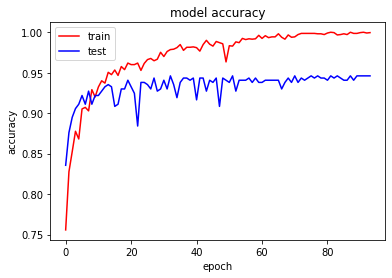

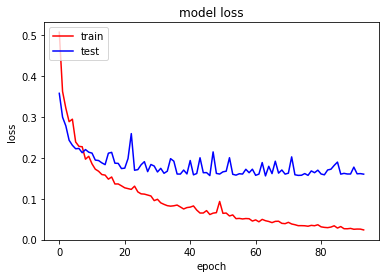

In [105]:
# Plot history
# Check for underfitting / overfitting based on the model loss history
# Determine the optimal number of training epochs. Use early stopping with model checkpoint saving.

# Accuray 
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [165]:
# Test the neural network on the test set. Use the following metrics: accuracy, recall, 
# precision, f1-score and the ROC/auRoc.

# Loading the the best performing model
VGG19.load_weights(checkpoint_filepath_transfer_VVG19)



# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
VGG19.save("./Model/VGG19.h5")


y_pred = np.argmax(VGG19.predict(X_test), axis=-1)


print('\n')
print(classification_report(y_test_original, y_pred))

cf = confusion_matrix(y_test_original, y_pred)
acc_vgg19 = accuracy_score(y_test_original, y_pred) * 100

print(cf)
print(acc_vgg19) 




              precision    recall  f1-score   support

           0       0.95      0.92      0.94       144
           1       0.92      0.95      0.93       131

    accuracy                           0.93       275
   macro avg       0.93      0.94      0.93       275
weighted avg       0.94      0.93      0.93       275

[[133  11]
 [  7 124]]
93.45454545454545


### Weighted average ensemble prediction (grid search for best combination of w1,w2,w3 that gives max acc)

In [163]:
#load model
VGG19 = keras.models.load_model('./Model/VGG19.h5')
OwnClassificationNN = keras.models.load_model('./Model/OwnClassificationNN_aug.h5')
OwnClassificationNNAUG = keras.models.load_model('./Model/OwnClassificationNN_aug.h5')

models = [VGG19, OwnClassificationNN, OwnClassificationNNAUG]
preds1 = [model.predict(X_test) for model in models]
preds1 = np.array(preds1)
#print(preds1)

#grid search for best combination of w1,w2,w3 that gives max acc

#create dataframe for weight 
df = pd.DataFrame([])

for w1 in range(0, 5):
    for w2 in range(0,5):
        for w3 in range(0,5):
            #weights gedeelt door 10, want moet in kommagetal
            wts = [w1/10., w2/10., w3/10.]
            wted_preds1 = np.tensordot(preds1, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(y_test_original, wted_ensemble_pred)
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],'wt3':wts[2],'acc':weighted_accuracy*100}, index=[0]))
            #print(df)

print(df)

   wt1  wt2  wt3        acc
0  0.0  0.0  0.0  52.363636
0  0.0  0.0  0.1  95.636364
0  0.0  0.0  0.2  95.636364
0  0.0  0.0  0.3  95.636364
0  0.0  0.0  0.4  95.636364
0  0.0  0.1  0.0  95.636364
0  0.0  0.1  0.1  95.636364
0  0.0  0.1  0.2  95.636364
0  0.0  0.1  0.3  95.636364
0  0.0  0.1  0.4  95.636364
0  0.0  0.2  0.0  95.636364
0  0.0  0.2  0.1  95.636364
0  0.0  0.2  0.2  95.636364
0  0.0  0.2  0.3  95.636364
0  0.0  0.2  0.4  95.636364
0  0.0  0.3  0.0  95.636364
0  0.0  0.3  0.1  95.636364
0  0.0  0.3  0.2  95.636364
0  0.0  0.3  0.3  95.636364
0  0.0  0.3  0.4  95.636364
0  0.0  0.4  0.0  95.636364
0  0.0  0.4  0.1  95.636364
0  0.0  0.4  0.2  95.636364
0  0.0  0.4  0.3  95.636364
0  0.0  0.4  0.4  95.636364
0  0.1  0.0  0.0  93.454545
0  0.1  0.0  0.1  96.363636
0  0.1  0.0  0.2  96.727273
0  0.1  0.0  0.3  96.363636
0  0.1  0.0  0.4  96.363636
0  0.1  0.1  0.0  96.363636
0  0.1  0.1  0.1  96.727273
0  0.1  0.1  0.2  96.363636
0  0.1  0.1  0.3  96.363636
0  0.1  0.1  0.4  96

In [161]:
df.head(100)

wt1  wt2  wt3        acc
0  0.0  0.0  0.0  52.363636
0  0.0  0.0  0.1  95.636364
0  0.0  0.0  0.2  95.636364
0  0.0  0.0  0.3  95.636364
0  0.0  0.0  0.4  95.636364
0  0.0  0.1  0.0  95.636364
0  0.0  0.1  0.1  95.636364
0  0.0  0.1  0.2  95.636364
0  0.0  0.1  0.3  95.636364
0  0.0  0.1  0.4  95.636364
0  0.0  0.2  0.0  95.636364
0  0.0  0.2  0.1  95.636364
0  0.0  0.2  0.2  95.636364
0  0.0  0.2  0.3  95.636364
0  0.0  0.2  0.4  95.636364
0  0.0  0.3  0.0  95.636364
0  0.0  0.3  0.1  95.636364
0  0.0  0.3  0.2  95.636364
0  0.0  0.3  0.3  95.636364
0  0.0  0.3  0.4  95.636364
0  0.0  0.4  0.0  95.636364
0  0.0  0.4  0.1  95.636364
0  0.0  0.4  0.2  95.636364
0  0.0  0.4  0.3  95.636364
0  0.0  0.4  0.4  95.636364
0  0.1  0.0  0.0  93.454545
0  0.1  0.0  0.1  96.363636
0  0.1  0.0  0.2  96.727273
0  0.1  0.0  0.3  96.363636
0  0.1  0.0  0.4  96.363636
0  0.1  0.1  0.0  96.363636
0  0.1  0.1  0.1  96.727273
0  0.1  0.1  0.2  96.363636
0  0.1  0.1  0.3  96.363636
0  0.1  0.1  0.4  96.363636
0  0.1  0.2  0.0  96.727273
0  0.1  0.2  0.1  96.363636
0  0.1  0.2  0.2  96.363636
0  0.1  0.2  0.3  96.363636
0  0.1  0.2  0.4  96.363636
0  0.1  0.3  0.0  96.363636
0  0.1  0.3  0.1  96.363636
0  0.1  0.3  0.2  96.363636
0  0.1  0.3  0.3  96.363636
0  0.1  0.3  0.4  96.363636
0  0.1  0.4  0.0  96.363636
0  0.1  0.4  0.1  96.363636
0  0.1  0.4  0.2  96.363636
0  0.1  0.4  0.3  96.363636
0  0.1  0.4  0.4  96.363636
0  0.2  0.0  0.0  93.454545
0  0.2  0.0  0.1  94.909091
0  0.2  0.0  0.2  96.363636
0  0.2  0.0  0.3  96.363636
0  0.2  0.0  0.4  96.727273
0  0.2  0.1  0.0  94.909091
0  0.2  0.1  0.1  96.363636
0  0.2  0.1  0.2  96.363636
0  0.2  0.1  0.3  96.727273
0  0.2  0.1  0.4  96.727273
0  0.2  0.2  0.0  96.363636
0  0.2  0.2  0.1  96.363636
0  0.2  0.2  0.2  96.727273
0  0.2  0.2  0.3  96.727273
0  0.2  0.2  0.4  96.363636
0  0.2  0.3  0.0  96.363636
0  0.2  0.3  0.1  96.727273
0  0.2  0.3  0.2  96.727273
0  0.2  0.3  0.3  96.363636
0  0.2  0.3  0.4  96.363636
0  0.2  0.4  0.0  96.727273
0  0.2  0.4  0.1  96.727273
0  0.2  0.4  0.2  96.363636
0  0.2  0.4  0.3  96.363636
0  0.2  0.4  0.4  96.363636
0  0.3  0.0  0.0  93.454545
0  0.3  0.0  0.1  94.545455
0  0.3  0.0  0.2  94.909091
0  0.3  0.0  0.3  96.363636
0  0.3  0.0  0.4  96.363636
0  0.3  0.1  0.0  94.545455
0  0.3  0.1  0.1  94.909091
0  0.3  0.1  0.2  96.363636
0  0.3  0.1  0.3  96.363636
0  0.3  0.1  0.4  96.727273
0  0.3  0.2  0.0  94.909091
0  0.3  0.2  0.1  96.363636
0  0.3  0.2  0.2  96.363636
0  0.3  0.2  0.3  96.727273
0  0.3  0.2  0.4  96.727273
0  0.3  0.3  0.0  96.363636
0  0.3  0.3  0.1  96.363636
0  0.3  0.3  0.2  96.727273
0  0.3  0.3  0.3  96.727273
0  0.3  0.3  0.4  96.727273
0  0.3  0.4  0.0  96.363636
0  0.3  0.4  0.1  96.727273
0  0.3  0.4  0.2  96.727273
0  0.3  0.4  0.3  96.727273
0  0.3  0.4  0.4  96.727273

In [171]:
#load model
VGG19 = keras.models.load_model('./Model/VGG19.h5')
OwnClassificationNN = keras.models.load_model('./Model/OwnClassificationNN_aug.h5')
OwnClassificationNNAUG = keras.models.load_model('./Model/OwnClassificationNN_aug.h5')

#predictions
models = [VGG19, OwnClassificationNN, OwnClassificationNNAUG]
preds = [model.predict(X_test) for model in models]
preds= np.array(preds)
weights = [0.35, 0.3, 0.35] #best weights
    
#use tensordot
weighted_pred = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_pred= np.argmax(weighted_pred, axis=1)


weighted_acc = accuracy_score(y_test_original, weighted_ensemble_pred)



print('\n')
print(classification_report(y_test_original, weighted_ensemble_pred))

cf = confusion_matrix(y_test_original, weighted_ensemble_pred)
acc_ensemble = (accuracy_score(y_test_original, weighted_ensemble_pred) * 100)

print(cf)
print(acc_ensemble) 








              precision    recall  f1-score   support

           0       0.97      0.97      0.97       144
           1       0.96      0.97      0.97       131

    accuracy                           0.97       275
   macro avg       0.97      0.97      0.97       275
weighted avg       0.97      0.97      0.97       275

[[139   5]
 [  4 127]]
96.72727272727273


In [172]:
print("accuracy of own model with augmentation:",acc_ownModel) 
print("accuracy of own model with augmentation:",acc_aug)
print("accuracy of vgg19:",acc_vgg19)
print("accuracy of ensemble model:",acc_ensemble)

accuracy of own model with augmentation: 95.27272727272728
accuracy of own model with augmentation: 95.63636363636364
accuracy of vgg19: 93.45454545454545
accuracy of ensemble model: 96.72727272727273


## Tumor Segmentation

### Data pre-processing

In [41]:
# Dice coefficient loss
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2.*intersection + smooth)/(K.sum(K.square(y_true),-1)+ K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [42]:
smooth=1.

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)git 
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [41]:
brain_df_mask = data_brain[data_brain['mask'] == 1]

In [46]:
# Create the pandas DataFrame
brain_df_mask = pd.DataFrame(data_brain_with, columns = ['file_images','file_masks','mask'])
brain_df_mask


file_images  \
0     ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
1     ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
2     ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
3     ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
4     ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
5     ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
6     ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
7     ./dataset/kaggle_3m\TCGA_CS_4941_19960909\TCGA...   
8     ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
9     ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
10    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
11    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
12    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
13    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
14    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
15    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
16    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
17    ./dataset/kaggle_3m\TCGA_CS_4942_19970222\TCGA...   
18    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
19    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
20    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
21    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
22    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
23    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
24    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
25    ./dataset/kaggle_3m\TCGA_CS_4943_20000902\TCGA...   
26    ./dataset/kaggle_3m\TCGA_CS_4944_20010208\TCGA...   
27    ./dataset/kaggle_3m\TCGA_CS_4944_20010208\TCGA...   
28    ./dataset/kaggle_3m\TCGA_CS_4944_20010208\TCGA...   
29    ./dataset/kaggle_3m\TCGA_CS_4944_20010208\TCGA...   
30    ./dataset/kaggle_3m\TCGA_CS_4944_20010208\TCGA...   
31    ./dataset/kaggle_3m\TCGA_CS_4944_20010208\TCGA...   
32    ./dataset/kaggle_3m\TCGA_CS_4944_20010208\TCGA...   
33    ./dataset/kaggle_3m\TCGA_CS_4944_20010208\TCGA...   
34    ./dataset/kaggle_3m\TCGA_CS_4944_20010208\TCGA...   
35    ./dataset/kaggle_3m\TCGA_CS_5393_19990606\TCGA...   
36    ./dataset/kaggle_3m\TCGA_CS_5393_19990606\TCGA...   
37    ./dataset/kaggle_3m\TCGA_CS_5393_19990606\TCGA...   
38    ./dataset/kaggle_3m\TCGA_CS_5393_19990606\TCGA...   
39    ./dataset/kaggle_3m\TCGA_CS_5393_19990606\TCGA...   
40    ./dataset/kaggle_3m\TCGA_CS_5393_19990606\TCGA...   
41    ./dataset/kaggle_3m\TCGA_CS_5393_19990606\TCGA...   
42    ./dataset/kaggle_3m\TCGA_CS_5393_19990606\TCGA...   
43    ./dataset/kaggle_3m\TCGA_CS_5395_19981004\TCGA...   
44    ./dataset/kaggle_3m\TCGA_CS_5395_19981004\TCGA...   
45    ./dataset/kaggle_3m\TCGA_CS_5396_20010302\TCGA...   
46    ./dataset/kaggle_3m\TCGA_CS_5396_20010302\TCGA...   
47    ./dataset/kaggle_3m\TCGA_CS_5396_20010302\TCGA...   
48    ./dataset/kaggle_3m\TCGA_CS_5396_20010302\TCGA...   
49    ./dataset/kaggle_3m\TCGA_CS_5396_20010302\TCGA...   
50    ./dataset/kaggle_3m\TCGA_CS_5396_20010302\TCGA...   
51    ./dataset/kaggle_3m\TCGA_CS_5396_20010302\TCGA...   
52    ./dataset/kaggle_3m\TCGA_CS_5396_20010302\TCGA...   
53    ./dataset/kaggle_3m\TCGA_CS_5396_20010302\TCGA...   
54    ./dataset/kaggle_3m\TCGA_CS_5396_20010302\TCGA...   
55    ./dataset/kaggle_3m\TCGA_CS_5397_20010315\TCGA...   
56    ./dataset/kaggle_3m\TCGA_CS_5397_20010315\TCGA...   
57    ./dataset/kaggle_3m\TCGA_CS_5397_20010315\TCGA...   
58    ./dataset/kaggle_3m\TCGA_CS_5397_20010315\TCGA...   
59    ./dataset/kaggle_3m\TCGA_CS_5397_20010315\TCGA...   
60    ./dataset/kaggle_3m\TCGA_CS_5397_20010315\TCGA...   
61    ./dataset/kaggle_3m\TCGA_CS_6186_20000601\TCGA...   
62    ./dataset/kaggle_3m\TCGA_CS_6186_20000601\TCGA...   
63    ./dataset/kaggle_3m\TCGA_CS_6186_20000601\TCGA...   
64    ./dataset/kaggle_3m\TCGA_CS_6186_20000601\TCGA...   
65    ./dataset/kaggle_3m\TCGA_CS_6186_20000601\TCGA...   
66    ./dataset/kaggle_3m\TCGA_CS_6186_20000601\TCGA...   
67    ./dataset/kaggle_3m\TCGA_C

In [48]:
brain_df_mask.file_images[1]

'./dataset/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12.tif'

In [49]:
#set the mask on the image. (to predict)
brain_tumor_mask = []

def image_merge(df):
    count = 0
    i = 0
    image_size=256
    for mask in df["mask"]:
        if mask == 1:
            # Show images
            image = io.imread(df.file_images[i])
            

            
            # Show masks
            mask = io.imread(df.file_masks[i])

            
            # merge MRI Brain with mask
            image[mask == 255] = (0, 255, 0)    # Here, we want to modify the color of pixel at the position of mask
            brain_tumor_mask.append(image)
           
            count += 1
            i += 1
        if count == 1373:
            break


In [50]:
image_merge(brain_df_mask)

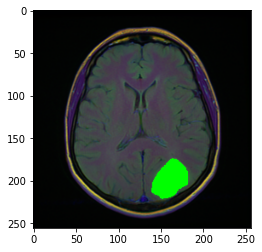

In [51]:
plt.imshow(brain_tumor_mask[100]) 

In [52]:
#resize to 128
image_size = 128
brain_tumor_mask_resized = []
for image in brain_tumor_mask:
        resized = transform.resize(image,(image_size,image_size),mode='constant',anti_aliasing=True)
        brain_tumor_mask_resized.append(resized)
        
brain_tumor_mask = brain_tumor_mask_resized

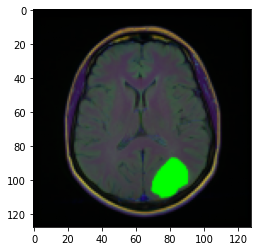

In [53]:
plt.imshow(brain_tumor_mask[100]) 

In [54]:
len(brain_tumor_mask)

1373

In [55]:
len(brain_image_with)

1373

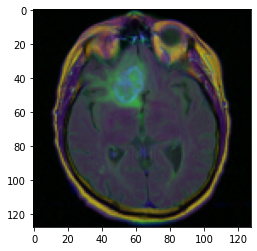

In [56]:
plt.imshow(brain_image_with[1])

In [57]:
# to array
brain_tumor_mask = np.asarray(brain_tumor_mask)
X = np.asarray(brain_image_with)


In [58]:
brain_tumor_mask

array([[[[0.        , 0.00294118, 0.        ],
         [0.        , 0.00588235, 0.00196078],
         [0.        , 0.00588235, 0.00196078],
         ...,
         [0.        , 0.00882353, 0.00490196],
         [0.        , 0.00784314, 0.00392157],
         [0.        , 0.00196078, 0.00588235]],

        [[0.        , 0.01372549, 0.00490196],
         [0.        , 0.00980392, 0.00490196],
         [0.        , 0.00784314, 0.00392157],
         ...,
         [0.        , 0.00882353, 0.00392157],
         [0.        , 0.00686275, 0.00392157],
         [0.        , 0.00980392, 0.00196078]],

        [[0.        , 0.01666667, 0.00392157],
         [0.        , 0.00882353, 0.00588235],
         [0.        , 0.00588235, 0.00588235],
         ...,
         [0.        , 0.00686275, 0.00588235],
         [0.        , 0.01078431, 0.00490196],
         [0.        , 0.01372549, 0.00196078]],

        ...,

        [[0.        , 0.00686275, 0.00196078],
         [0.        , 0.01764706, 0.00392157]

In [59]:
X

array([[[[0.        , 0.00294118, 0.        ],
         [0.        , 0.00588235, 0.00196078],
         [0.        , 0.00588235, 0.00196078],
         ...,
         [0.        , 0.00882353, 0.00490196],
         [0.        , 0.00784314, 0.00392157],
         [0.        , 0.00196078, 0.00588235]],

        [[0.        , 0.01372549, 0.00490196],
         [0.        , 0.00980392, 0.00490196],
         [0.        , 0.00784314, 0.00392157],
         ...,
         [0.        , 0.00882353, 0.00392157],
         [0.        , 0.00686275, 0.00392157],
         [0.        , 0.00980392, 0.00196078]],

        [[0.        , 0.01666667, 0.00392157],
         [0.        , 0.00882353, 0.00588235],
         [0.        , 0.00588235, 0.00588235],
         ...,
         [0.        , 0.00686275, 0.00588235],
         [0.        , 0.01078431, 0.00490196],
         [0.        , 0.01372549, 0.00196078]],

        ...,

        [[0.        , 0.00686275, 0.00196078],
         [0.        , 0.01764706, 0.00392157]

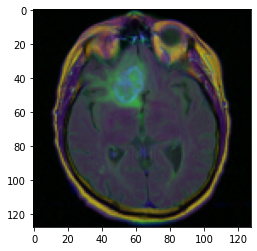

In [60]:
plt.imshow(X[1])

In [61]:
X_train_with_mask, X_test_with_mask, y_train_with_mask, y_test_with_mask = train_test_split(X, brain_tumor_mask, test_size = 0.1, random_state =0)

#validation data
X_train_with_mask, X_val_with_mask, y_train_with_mask, y_val_with_mask = train_test_split(X_train_with_mask, y_train_with_mask, test_size = 0.1, random_state =0)


In [62]:
# Image normalization when necessary
# Normalisatie
X_train_with_mask = X_train_with_mask.astype('float32')
X_test_with_mask = X_test_with_mask.astype('float32')
X_val_with_mask = X_val_with_mask.astype('float32')
#X_train /= 255 #-> moet uitgevoerd worden, want de input is niet tussen 0 -> 1  
#X_test /= 255

y_train_with_mask = y_train_with_mask.astype('float32')
y_test_with_mask = y_test_with_mask.astype('float32')
y_val_with_mask = y_val_with_mask.astype('float32')
#y_train /= 255 #-> moet uitgevoerd worden, want de input is niet tussen 0 -> 1  
#y_test /= 255 

#y_train = np.round(y_train)


In [63]:
print(X_train_with_mask.shape)
print(y_train_with_mask.shape)

print(X_test_with_mask.shape)
print(y_test_with_mask.shape)

print(X_val_with_mask.shape)
print(y_val_with_mask.shape)

(1111, 128, 128, 3)
(1111, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(124, 128, 128, 3)
(124, 128, 128, 3)


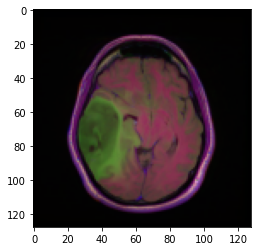

In [64]:
plt.imshow(X_val_with_mask[6])

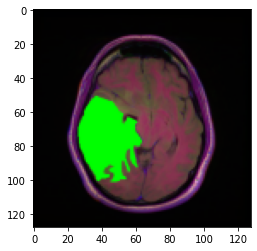

In [65]:
plt.imshow(y_val_with_mask[6])

### Unet segmentation

#### https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277#Intro
<img src="./diagram/download.png">

In [66]:
%%time

# Build U-Net model


inputs = Input((128, 128, 3))
s = Lambda(lambda x: x / 255) (inputs)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)



c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)



u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)




outputs = Conv2D(3, (1, 1), activation='sigmoid') (c9)

UNet = Model(inputs=[inputs], outputs=[outputs])
UNet.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef, dice_coef_loss])


# Fit model
# Fit model
checkpoint_filepath_unet = './bestmodel_unet'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath_unet,save_weights_only=True, monitor='val_loss',mode='auto',save_best_only=True)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)


results = UNet.fit(X_train_with_mask, y_train_with_mask, validation_data=(X_val_with_mask,y_val_with_mask),batch_size=64, epochs=200, 
                   callbacks=[mc, es])





Epoch 1/200
18/18 [==============================] - 7s 183ms/step - loss: 0.4794 - dice_coef: 0.8512 - dice_coef_loss: 0.1488 - val_loss: 0.3501 - val_dice_coef: 0.9436 - val_dice_coef_loss: 0.0564
Epoch 2/200
18/18 [==============================] - 2s 89ms/step - loss: 0.3550 - dice_coef: 0.9321 - dice_coef_loss: 0.0679 - val_loss: 0.3250 - val_dice_coef: 0.9496 - val_dice_coef_loss: 0.0504
Epoch 3/200
18/18 [==============================] - 2s 89ms/step - loss: 0.3211 - dice_coef: 0.9495 - dice_coef_loss: 0.0505 - val_loss: 0.3276 - val_dice_coef: 0.9504 - val_dice_coef_loss: 0.0496
Epoch 4/200
18/18 [==============================] - 2s 89ms/step - loss: 0.2952 - dice_coef: 0.9606 - dice_coef_loss: 0.0394 - val_loss: 0.2965 - val_dice_coef: 0.9617 - val_dice_coef_loss: 0.0383
Epoch 5/200
18/18 [==============================] - 2s 87ms/step - loss: 0.2834 - dice_coef: 0.9655 - dice_coef_loss: 0.0345 - val_loss: 0.2810 - val_dice_coef: 0.9679 - val_dice_coef_loss: 0.0321
Epoch 6/2

18/18 [==============================] - 2s 90ms/step - loss: 0.2212 - dice_coef: 0.9955 - dice_coef_loss: 0.0045 - val_loss: 0.2244 - val_dice_coef: 0.9948 - val_dice_coef_loss: 0.0052
Epoch 84/200
18/18 [==============================] - 2s 90ms/step - loss: 0.2211 - dice_coef: 0.9955 - dice_coef_loss: 0.0045 - val_loss: 0.2230 - val_dice_coef: 0.9951 - val_dice_coef_loss: 0.0049
Epoch 85/200
18/18 [==============================] - 2s 89ms/step - loss: 0.2211 - dice_coef: 0.9956 - dice_coef_loss: 0.0044 - val_loss: 0.2230 - val_dice_coef: 0.9951 - val_dice_coef_loss: 0.0049
Epoch 86/200
18/18 [==============================] - 2s 88ms/step - loss: 0.2211 - dice_coef: 0.9956 - dice_coef_loss: 0.0044 - val_loss: 0.2244 - val_dice_coef: 0.9949 - val_dice_coef_loss: 0.0051
Epoch 87/200
18/18 [==============================] - 2s 88ms/step - loss: 0.2208 - dice_coef: 0.9957 - dice_coef_loss: 0.0043 - val_loss: 0.2232 - val_dice_coef: 0.9951 - val_dice_coef_loss: 0.0049
Epoch 88/200
18/18

18/18 [==============================] - 2s 87ms/step - loss: 0.2168 - dice_coef: 0.9976 - dice_coef_loss: 0.0024 - val_loss: 0.2187 - val_dice_coef: 0.9972 - val_dice_coef_loss: 0.0028
Epoch 166/200
18/18 [==============================] - 2s 87ms/step - loss: 0.2168 - dice_coef: 0.9977 - dice_coef_loss: 0.0023 - val_loss: 0.2192 - val_dice_coef: 0.9972 - val_dice_coef_loss: 0.0028
Epoch 167/200
18/18 [==============================] - 2s 86ms/step - loss: 0.2169 - dice_coef: 0.9976 - dice_coef_loss: 0.0024 - val_loss: 0.2193 - val_dice_coef: 0.9972 - val_dice_coef_loss: 0.0028
Epoch 168/200
18/18 [==============================] - 2s 86ms/step - loss: 0.2169 - dice_coef: 0.9977 - dice_coef_loss: 0.0023 - val_loss: 0.2201 - val_dice_coef: 0.9970 - val_dice_coef_loss: 0.0030
Epoch 169/200
18/18 [==============================] - 2s 87ms/step - loss: 0.2167 - dice_coef: 0.9977 - dice_coef_loss: 0.0023 - val_loss: 0.2195 - val_dice_coef: 0.9972 - val_dice_coef_loss: 0.0028
Epoch 170/200


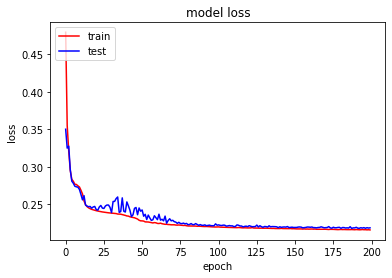

In [67]:
# Plot history
# Check for underfitting / overfitting based on the model loss history
# Determine the optimal number of training epochs. Use early stopping with model checkpoint saving.

# Loss 
plt.plot(results.history['loss'],'r')
plt.plot(results.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [68]:
print(UNet.evaluate(X_test_with_mask,y_test_with_mask))

5/5 [==============================] - 1s 80ms/step - loss: 0.2239 - dice_coef: 0.9976 - dice_coef_loss: 0.0024
[0.22394394874572754, 0.9976189732551575, 0.0023810456041246653]


(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)


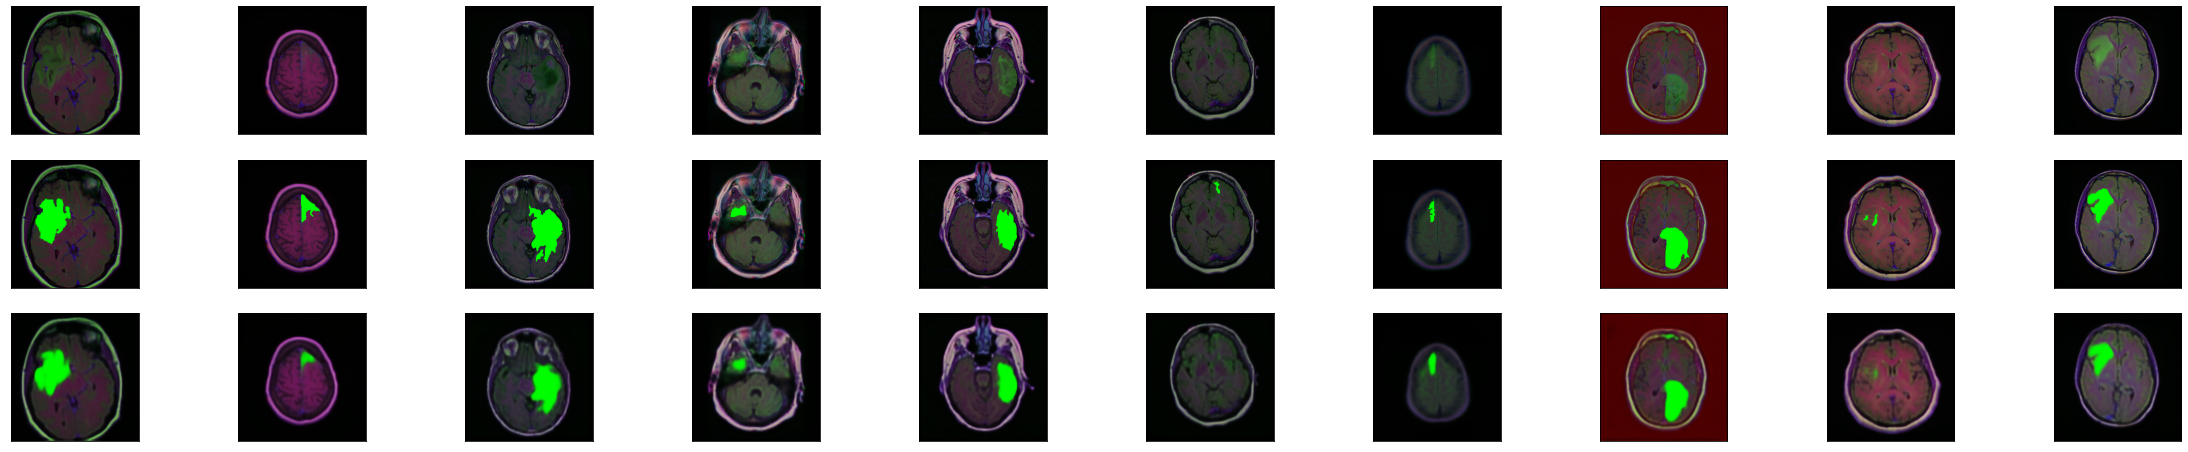

dice coef score: tf.Tensor(0.91717654, shape=(), dtype=float32)


In [92]:
# Testing
# Loading the the best performing model
UNet.load_weights(checkpoint_filepath_unet)

# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
UNet.save("./Model/UNet.h5")

decoded_imgs = UNet.predict(X_test_with_mask)
print(X_test_with_mask.shape)
n = 10 # number of images to plot
plt.figure(figsize=(40, 8))
for i in range(n):
    # Originals
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test_with_mask[i].reshape(image_size, image_size,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    # Originals mask
    ax = plt.subplot(3, n, i + 1+ n)
    print(X_test_with_mask.shape)
    plt.imshow(y_test_with_mask[i].reshape(image_size, image_size,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructions
    ax = plt.subplot(3, n, i + 1 + n +n)
    plt.imshow(decoded_imgs[i].reshape(image_size, image_size,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


dice_coef_unet = dice_coef(X_test_with_mask.flatten(),decoded_imgs.flatten())
print("dice coef score:", dice_coef_unet)


### DeepLabv3+ (multi-class segmentation) ResNet50 pretrained on ImageNet as the backbone model

Atrous Spatial Pyramid Pooling (ASSP) is a semantic segmentation module for resampling a given feature layer at multiple rates prior to convolution. This amounts to probing the original image with multiple filters that have complementary effective fields of view, thus capturing objects as well as useful image context at multiple scales. Rather than actually resampling features, the mapping is implemented using multiple parallel atrous convolutional layers with different sampling rates.


<img src="./diagram/00204_PSISDG11533_115330M_page_4_1.jpg">

#### https://keras.io/examples/vision/deeplabv3_plus/
<img src="./diagram/deeplabv3_plus_diagram.png">

In [70]:
%%time

""" Atrous Spatial Pyramid Pooling """
def ASPP(inputs):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=128, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)  
    y_pool = Dropout(0.1) (y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=128, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Dropout(0.1) (y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=128, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Dropout(0.1) (y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=128, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Dropout(0.1) (y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=128, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Dropout(0.2) (y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=128, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

def DeepLabV3Plus(shape):
    """ Inputs """
    inputs = Input(shape)

    """ Pre-trained ResNet50 """
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    """ Pre-trained ResNet50 Output """
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    """ Get low-level features """
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=32, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    """ Outputs """
    x = Conv2D(3, (1, 1), name='output_layer')(x)
    x = Activation('sigmoid')(x)

    """ Model """
    DeepLabPlus1 = Model(inputs=inputs, outputs=x)
    return DeepLabPlus1

if __name__ == "__main__":
    input_shape = (image_size, image_size, 3)
    DeepLabPlus1 = DeepLabV3Plus(input_shape)
    DeepLabPlus1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [71]:
%%time
# Fit model
checkpoint_filepath_deeplabplus = './bestmodel_deeplabplus'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath_deeplabplus,save_weights_only=True, monitor='val_loss',mode='auto',save_best_only=True)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 50)

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
DeepLabPlus1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
     loss='binary_crossentropy', metrics=[dice_coef, dice_coef_loss]
)

history = DeepLabPlus1.fit(X_train_with_mask,y_train_with_mask,validation_data=(X_val_with_mask,y_val_with_mask),batch_size=32, epochs=500,callbacks=[mc, es])


Epoch 1/500
35/35 [==============================] - 17s 295ms/step - loss: 0.3340 - dice_coef: 0.9355 - dice_coef_loss: 0.0645 - val_loss: 0.7445 - val_dice_coef: 0.7067 - val_dice_coef_loss: 0.2933
Epoch 2/500
35/35 [==============================] - 6s 166ms/step - loss: 0.2374 - dice_coef: 0.9891 - dice_coef_loss: 0.0109 - val_loss: 0.3380 - val_dice_coef: 0.9261 - val_dice_coef_loss: 0.0739
Epoch 3/500
35/35 [==============================] - 6s 167ms/step - loss: 0.2284 - dice_coef: 0.9924 - dice_coef_loss: 0.0076 - val_loss: 0.2905 - val_dice_coef: 0.9633 - val_dice_coef_loss: 0.0367
Epoch 4/500
35/35 [==============================] - 6s 167ms/step - loss: 0.2253 - dice_coef: 0.9935 - dice_coef_loss: 0.0065 - val_loss: 0.2819 - val_dice_coef: 0.9679 - val_dice_coef_loss: 0.0321
Epoch 5/500
35/35 [==============================] - 6s 166ms/step - loss: 0.2235 - dice_coef: 0.9941 - dice_coef_loss: 0.0059 - val_loss: 0.2850 - val_dice_coef: 0.9658 - val_dice_coef_loss: 0.0342
Epoc

35/35 [==============================] - 6s 166ms/step - loss: 0.2185 - dice_coef: 0.9962 - dice_coef_loss: 0.0038 - val_loss: 0.2211 - val_dice_coef: 0.9954 - val_dice_coef_loss: 0.0046
Epoch 43/500
35/35 [==============================] - 6s 166ms/step - loss: 0.2183 - dice_coef: 0.9963 - dice_coef_loss: 0.0037 - val_loss: 0.2209 - val_dice_coef: 0.9954 - val_dice_coef_loss: 0.0046
Epoch 44/500
35/35 [==============================] - 6s 166ms/step - loss: 0.2183 - dice_coef: 0.9963 - dice_coef_loss: 0.0037 - val_loss: 0.2209 - val_dice_coef: 0.9954 - val_dice_coef_loss: 0.0046
Epoch 45/500
35/35 [==============================] - 6s 166ms/step - loss: 0.2184 - dice_coef: 0.9962 - dice_coef_loss: 0.0038 - val_loss: 0.2213 - val_dice_coef: 0.9953 - val_dice_coef_loss: 0.0047
Epoch 46/500
35/35 [==============================] - 6s 166ms/step - loss: 0.2184 - dice_coef: 0.9962 - dice_coef_loss: 0.0038 - val_loss: 0.2215 - val_dice_coef: 0.9951 - val_dice_coef_loss: 0.0049
Epoch 47/500


35/35 [==============================] - 6s 166ms/step - loss: 0.2177 - dice_coef: 0.9965 - dice_coef_loss: 0.0035 - val_loss: 0.2214 - val_dice_coef: 0.9955 - val_dice_coef_loss: 0.0045
Epoch 84/500
35/35 [==============================] - 6s 166ms/step - loss: 0.2177 - dice_coef: 0.9965 - dice_coef_loss: 0.0035 - val_loss: 0.2210 - val_dice_coef: 0.9956 - val_dice_coef_loss: 0.0044
Epoch 85/500
35/35 [==============================] - 6s 166ms/step - loss: 0.2177 - dice_coef: 0.9965 - dice_coef_loss: 0.0035 - val_loss: 0.2210 - val_dice_coef: 0.9955 - val_dice_coef_loss: 0.0045
Epoch 86/500
35/35 [==============================] - 6s 166ms/step - loss: 0.2177 - dice_coef: 0.9965 - dice_coef_loss: 0.0035 - val_loss: 0.2213 - val_dice_coef: 0.9955 - val_dice_coef_loss: 0.0045
Epoch 87/500
35/35 [==============================] - 6s 166ms/step - loss: 0.2176 - dice_coef: 0.9965 - dice_coef_loss: 0.0035 - val_loss: 0.2211 - val_dice_coef: 0.9954 - val_dice_coef_loss: 0.0046
Epoch 88/500


In [72]:
print(DeepLabPlus1.evaluate(X_test_with_mask,y_test_with_mask)) 

5/5 [==============================] - 1s 202ms/step - loss: 0.2266 - dice_coef: 0.9957 - dice_coef_loss: 0.0043
[0.22658497095108032, 0.9957224726676941, 0.004277519881725311]


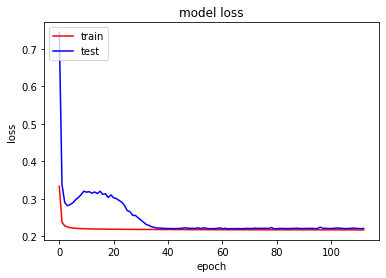

In [73]:
# Plot history
# Check for underfitting / overfitting based on the model loss history
# Determine the optimal number of training epochs. Use early stopping with model checkpoint saving.

# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)


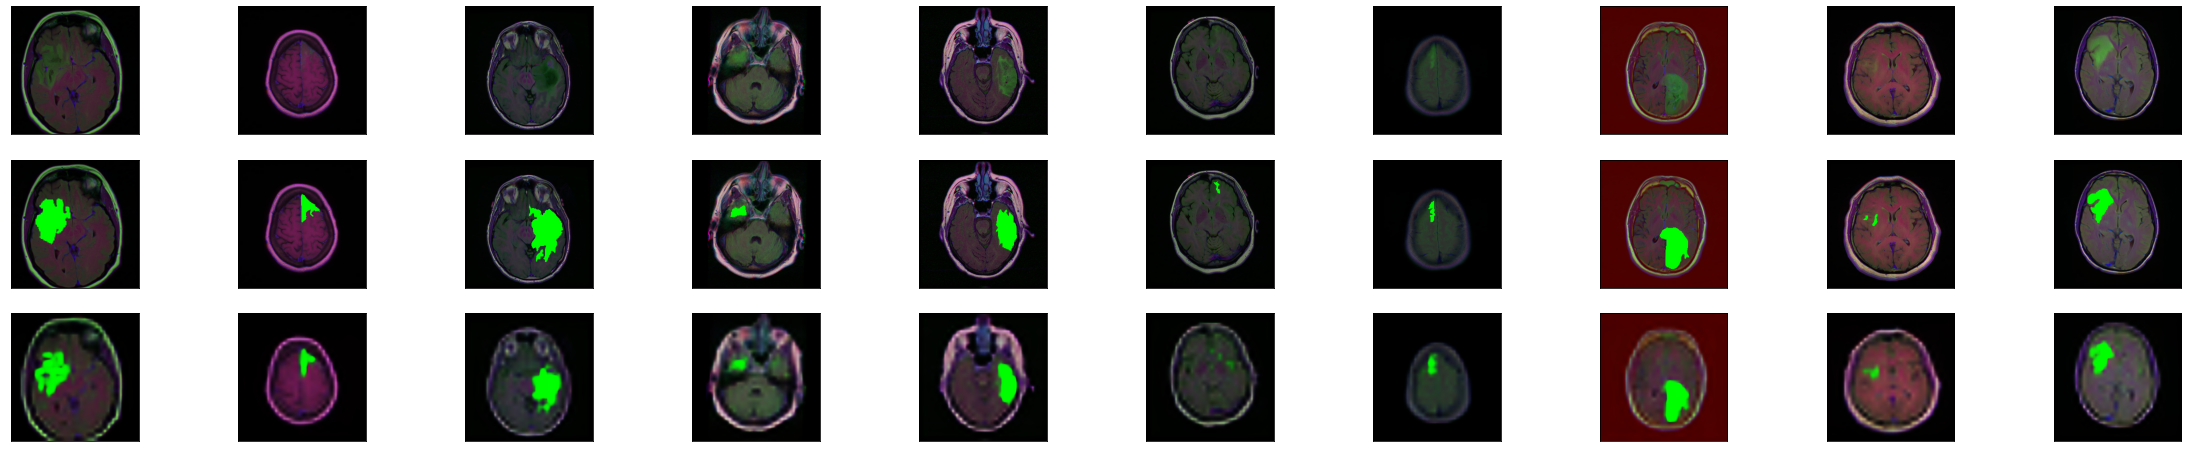

dice coef score: tf.Tensor(0.90103424, shape=(), dtype=float32)


In [88]:
# Testing
# Loading the the best performing model
DeepLabPlus1.load_weights(checkpoint_filepath_deeplabplus)



# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
DeepLabPlus1.save("./Model/DeepLabPlus.h5")


decoded_imgs = DeepLabPlus1.predict(X_test_with_mask)
print(X_test_with_mask.shape)
n = 10 # number of images to plot
plt.figure(figsize=(40, 8))
for i in range(n):
    # Originals
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test_with_mask[i].reshape(image_size, image_size,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    # Originals mask
    ax = plt.subplot(3, n, i + 1+ n)
    print(X_test_with_mask.shape)
    plt.imshow(y_test_with_mask[i].reshape(image_size, image_size,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructions
    ax = plt.subplot(3, n, i + 1 + n +n)
    plt.imshow(decoded_imgs[i].reshape(image_size, image_size,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

dice_coef_deeplab = dice_coef(X_test_with_mask.flatten(),decoded_imgs.flatten())
print("dice coef score:", dice_coef_deeplab)

### Ensemble segmentation

In [85]:
# Dice coefficient loss
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2.*intersection + smooth)/(K.sum(K.square(y_true),-1)+ K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


#load model
DeeplabModel = keras.models.load_model('./Model/DeepLabPlus.h5', custom_objects={"dice_coef": dice_coef,"dice_coef_loss": dice_coef_loss})
UnetModel = keras.models.load_model('./Model/UNet.h5', custom_objects={"dice_coef": dice_coef,"dice_coef_loss": dice_coef_loss })

#predictions
models = [DeeplabModel, UnetModel]
preds = [model.predict(X_test_with_mask) for model in models]
preds= np.array(preds)
weights = [0.3,0.7] #best weights


    
#use tensordot
weighted_pred = np.tensordot(preds, weights, axes=((0),(0)))
#weighted_ensemble_pred= np.argmax(weighted_pred, axis=1)


weighted_pred = np.float32(weighted_pred)

#intersection = np.logical_and(X_test_with_mask, weighted_pred)
#union = np.logical_or(X_test_with_mask, weighted_pred)
#iou_score_ensemble = np.sum(intersection) / np.sum(union)





dice_coef_ensemble = dice_coef(X_test_with_mask.flatten(),weighted_pred.flatten())
print("dice_coef_ensemble: ", dice_coef_ensemble)





iou_score_ensemble:  tf.Tensor(0.9169625, shape=(), dtype=float32)


(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)
(138, 128, 128, 3)


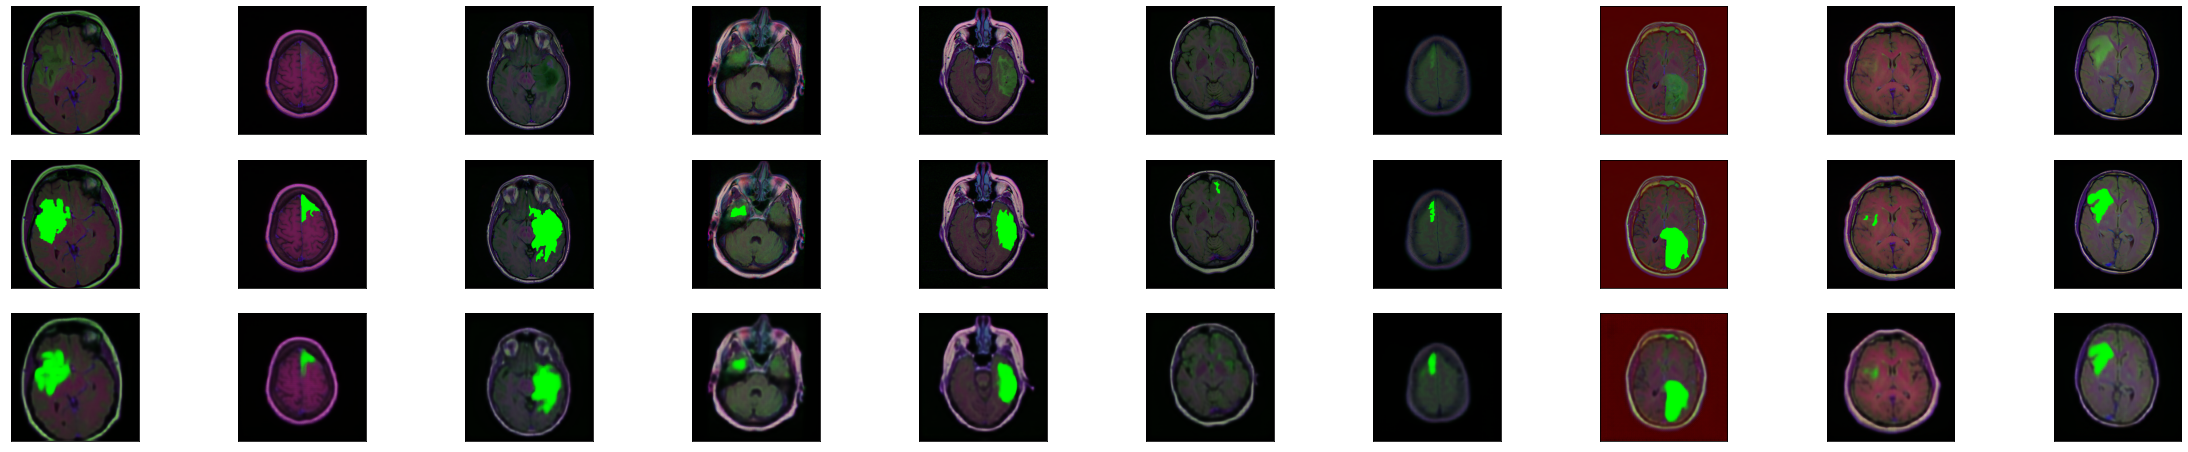

In [86]:
plt.figure(figsize=(40, 8))
for i in range(n):
    # Originals
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test_with_mask[i].reshape(image_size, image_size,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    # Originals mask
    ax = plt.subplot(3, n, i + 1+ n)
    print(X_test_with_mask.shape)
    plt.imshow(y_test_with_mask[i].reshape(image_size, image_size,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructions
    ax = plt.subplot(3, n, i + 1 + n +n)
    plt.imshow(weighted_pred[i].reshape(image_size, image_size,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### iou_score segmentation modellen

In [93]:
print("dice_score_ensemble: ", dice_coef_ensemble)
print("dice_score_deeplabv3: ", dice_coef_deeplab)
print("dice_score_unet: ", dice_coef_unet)



dice_score_ensemble:  tf.Tensor(0.9169625, shape=(), dtype=float32)
dice_score_deeplabv3:  tf.Tensor(0.90103424, shape=(), dtype=float32)
dice_score_unet:  tf.Tensor(0.91717654, shape=(), dtype=float32)


## Applicatie 

Een image of list van images die eerst door de classificatie part gaat. Indien de brain image een tumor bevat zal het ook door de segmentatie gaan. Dit applicatie is gemaakt als hulpmiddel voor de dokter en niet als vervanger. 

A list of images that first go trought the classification part. If the model predictics that the image contains a tumor, then it will been forwarded to the segmentation model.

In [8]:

%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.utils import shuffle

import cv2


import matplotlib.image as mpimg
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from scipy import ndimage

from sklearn.preprocessing import StandardScaler
import seaborn as sns




import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization,concatenate
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras import backend as K
from tensorflow.python.keras.layers.core import Dropout, Lambda
from tensorflow.python.keras.layers.core import * 
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.text import Tokenizer

import glob


from tensorflow.keras.callbacks import *
# Voor GPU support
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

pd.set_option('display.max_rows',10000)
pd.set_option('display.max_columns',10000)

### list images toekennen 


In [9]:
path_images = './dataset/test/'

# Separate images and masks in the directory
images_dir = glob.glob(path_images + "*.tif")

In [10]:
image_dir = []
for images in images_dir:
    #image = imread(images)
    image = images
    image_dir.append(image)

images = image_dir

### Uitvoering

In [11]:
# Dice coefficient loss
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2.*intersection + smooth)/(K.sum(K.square(y_true),-1)+ K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# model inlezen 
#read model
#load model
VGG19 = keras.models.load_model('./Model/VGG19.h5')
OwnClassificationNN = keras.models.load_model('./Model/OwnClassificationNN_aug.h5')
OwnClassificationNNAUG = keras.models.load_model('./Model/OwnClassificationNN_aug.h5')
segmentationmodel = keras.models.load_model('./Model/UNet.h5', custom_objects={"dice_coef": dice_coef,"dice_coef_loss": dice_coef_loss })

if len(images) > 1:
    #resize to 128
    image_size = 128
    images_resized = []
    i = 0
    #reading images & resize 
    for image in images:
        
        #inlezen
        image = imread(images[i])
       
        #resize
        resized = transform.resize(image,(image_size,image_size),mode='constant',anti_aliasing=True)
        images_resized.append(resized)
        
        i += 1
        if i > len(images):
            break
        
    images = images_resized
    images = np.asarray(images)
    print(images.shape)
    
    # classificatie 
    # (if tumor ->> naar segmantatie model doorsturen) 
    # (if not ->> show images en vermeld dat er geen tumor is gevonden.
    class1 = []
    class0 = []
    predictions = []
    i = 0
    for eachImage in images:
        # # reshape naar 1,image_size,image_size,3
        eachImage = np.asarray(eachImage)
        eachImage = eachImage.reshape(1,image_size, image_size,3)
    
        #prediction class
        #predictions
        models = [VGG19, OwnClassificationNN, OwnClassificationNNAUG]
        preds = [model.predict(eachImage) for model in models]
        preds= np.array(preds)
        weights = [0.35, 0.3, 0.35] #best weights

        #use tensordot
        weighted_pred = np.tensordot(preds, weights, axes=((0),(0)))
        predictionClassification= np.argmax(weighted_pred, axis=1)

        
        #predictionClassification = OwnClassificationNN.predict(eachImage)
        #predictionClassification = np.argmax(predictionClassification)
        
        print(predictionClassification)
        if predictionClassification == 1:
            
            
            # Segmentation
            predictionSegmentation = segmentationmodel.predict(eachImage)
            #print("Segmentation: ",segmentationmodel)

            # reshape naar 1,image_size,image_size,3
            predictionSegmentation = predictionSegmentation.reshape(image_size, image_size,3)
            
            class1.append(predictionSegmentation)
            predictions.append(predictionSegmentation)  
        else:
            # reshape naar image_size,image_size,3
            eachImage = eachImage.reshape(image_size, image_size,3)
            
            #append image without tumor
            class0.append(eachImage)
            
            predictions.append(eachImage)
            
        i += 1
        if i > len(images):
            break



(4, 128, 128, 3)
[0]
[0]
[1]
[1]


### List - No tumor detected

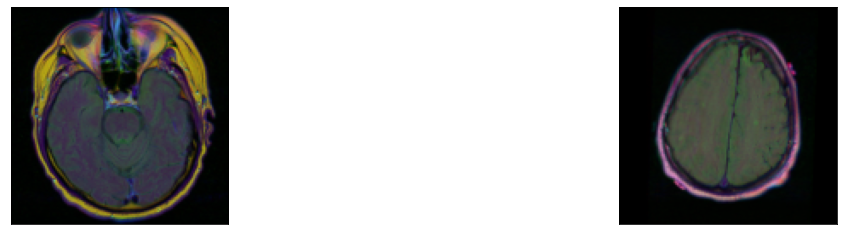

In [12]:
n = len(class0) # number of images to plot
plt.figure(figsize=(20, 4))
for i in range(n):
    # Originals mask
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(class0[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### List - tumor detected

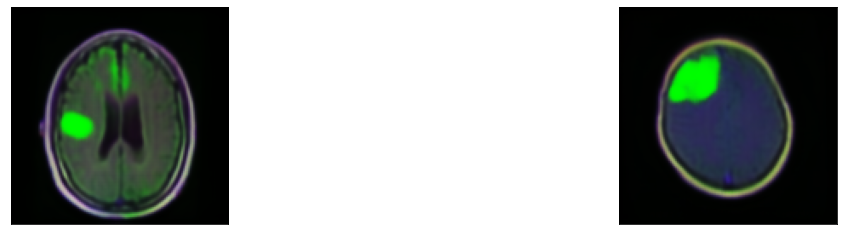

In [13]:
n = len(class1) # number of images to plot
plt.figure(figsize=(20, 4))
for i in range(n):
    # Reconstructions
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(class1[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### -------- END APPLICATION --------

### check prediction with mask (test)

In [166]:
path_mask = './dataset/test_masks/Mask/'

# Separate images and masks in the directory
masks_dir = glob.glob(path_mask + "*_mask*")

In [167]:
mask_dir = []
for masks in masks_dir:
    mask = imread(masks)
    mask_dir.append(mask)

masks = mask_dir

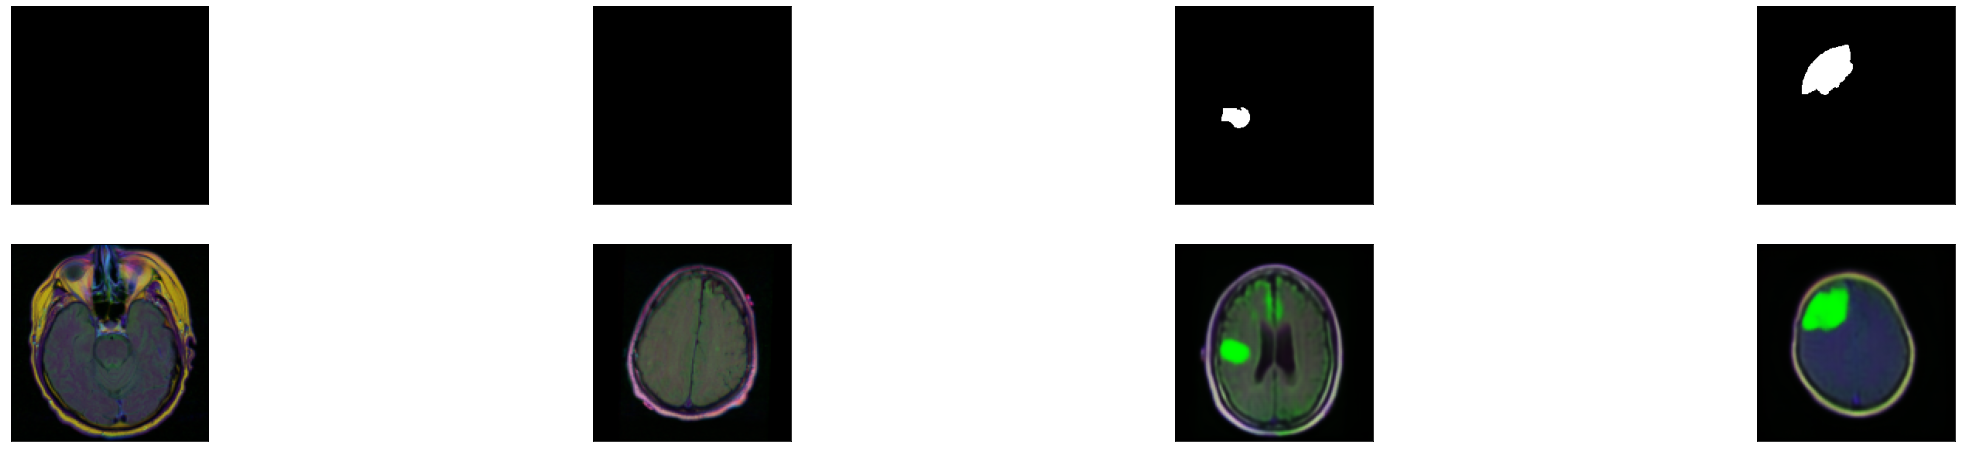

In [170]:
n = len(masks) # number of images to plot
plt.figure(figsize=(40, 8))
for i in range(n):
    # Originals mask
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(masks[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructions
    ax = plt.subplot(2, n, i + 1 + n )
    plt.imshow(predictions[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()